# Data

In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# 0. Imports & reproducibility
# ────────────────────────────────────────────────────────────────────────────────
import math, random, numpy as np, torch
from torch import nn
# Basic
import torch
import math
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import numpy as np
from numpy import random
# torch.set_num_threads(4)

# PDEi
from utils_pde.utils_pde_2dpoisson import Poisson2D

# Viz
from utils_tools.utils_result_viz import plot_predictions_2D
from utils_tools.utils_tuning import save_plot

# Base Mdoels
from utils_uqmd.utils_uq_dropout import DropoutPINN
from utils_uqmd.utils_uq_mlp import MLPPINN
from utils_uqmd.utils_uq_vi import VIBPINN
from utils_uqmd.utils_uq_distance import DistanceUQPINN

# CP
from utils_uqmd.utils_uq_cp import CP

torch.set_num_threads(4)
seed = 5902
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# ────────────────────────────────────────────────────────────────────────────────
# 1. Ground-truth PDE setup 
# ────────────────────────────────────────────────────────────────────────────────
from utils_pde.utils_pde_allencahn2d import AllenCahn2D

# 1) keep the torch-based definition
def true_solution(xy):
    return torch.sin(math.pi*xy[...,0:1]) * torch.sin(math.pi*xy[...,1:2])

domain=((-1.0, 1.0), (-1.0, 1.0))
pde = AllenCahn2D(lam=0.05, domain=domain, true_solution=true_solution)

# ────────────────────────────────────────────────────────────────────────────────
# 2. Data Generation (Noisy data for training, test, calibration)
# ────────────────────────────────────────────────────────────────────────────────
colloc_pt_num = 1024  # Number of collocation points

data_noise = 0.05
N_train = 300
N_test = 100
N_calib = 100
N_valid = 200

N_total= N_train+N_test+N_calib

X_train, Y_train = pde.data_generation(N_train, data_noise)
X_test, Y_test = pde.data_generation(N_test, data_noise)
X_calibration, Y_calibration = pde.data_generation(N_calib, data_noise)
X_validation, Y_validation= pde.data_generation(N_valid, data_noise)

X_vis, Y_vis = pde.data_generation(N_total, data_noise)
# Generating alphas to test
from utils_tools.utils_result_metrics import generating_alphas
alphas = generating_alphas()

alpha = 0.05

# ────────────────────────────────────────────────────────────────────────────────
# 3. Visualization: Plot ground-truth & noisy data
# ────────────────────────────────────────────────────────────────────────────────

def make_dense_grid(domain, N=200):
    x = np.linspace(domain[0][0], domain[0][1], N)
    y = np.linspace(domain[1][0], domain[1][1], N)
    X, Y = np.meshgrid(x, y)
    XY_grid = np.stack([X.ravel(), Y.ravel()], axis=-1)
    return XY_grid, X, Y

import matplotlib.pyplot as plt

def plot_truth_and_samples_2D(
    X_train, Y_train, grid, U_true_grid, domain,
    title="Allen-Cahn 2D: ground-truth vs noisy data"
):
    fig, ax = plt.subplots(figsize=(7, 6))
    # Show the true solution as a colormap
    x = np.linspace(domain[0][0], domain[0][1], U_true_grid.shape[0])
    y = np.linspace(domain[1][0], domain[1][1], U_true_grid.shape[1])
    im = ax.imshow(
        U_true_grid,
        extent=(domain[0][0], domain[0][1], domain[1][0], domain[1][1]),
        origin='lower',
        aspect='auto',
        alpha=0.8,
        cmap='coolwarm'
    )
    # Overlay noisy training points
    ax.scatter(X_train[:,0], X_train[:,1], c=Y_train, edgecolor='k', cmap='viridis', s=18, label="Noisy samples")
    plt.colorbar(im, ax=ax, label="u(x, y)")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()



# 4) plot again
grid_test, X_mesh, Y_mesh = make_dense_grid(domain, 10)
grid_test_torch = torch.tensor(grid_test, dtype=torch.float32)
U_true_grid = true_solution(grid_test_torch).numpy().reshape(X_mesh.shape)

save_plot(
    plot_truth_and_samples_2D,
    save_dir="2D_AllenCahn", prefix="2D_AllenCahn_data",
)(
    X_vis, Y_vis, grid_test, U_true_grid, domain,
    title="Allen-Cahn 2D: ground-truth vs noisy data"
)


# --------------------------------------------
# Defining Testing
# --------------------------------------------
n_grid = 200
x = torch.linspace(1.0, -1.0, n_grid)
y = torch.linspace(1.0, -1.0, n_grid)
X, Y = torch.meshgrid(x, y, indexing='xy')
grid_test = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)


grid_test, u = pde.solution_field_on_grid(n_grid, include_boundary=True, flatten=True, source="true")



<Figure size 640x480 with 0 Axes>

# Plotting Helpers

In [2]:
def plot_coverage_comparison(
    df_uncal,
    df_cal,
    *,
    alpha_col: str = "alpha",
    cov_col: str = "coverage",
    labels=("Before CP", "After CP"),
    title: str = "Coverage Comparison",
    ax=None,
    # --- NEW style controls to align with field plots ---
    figsize=(6, 5),          # match plot_uq_field default
    n_ticks: int = 9,        # number of major ticks on each axis (incl. endpoints)
    font_size: int = 12,     # label/title font
    tick_size: int = 10,     # tick label size
    grid_alpha: float = 0.2, # grid transparency
    box_aspect: float = 1.0, # make axes square like your field panels
):
    """
    Plot empirical vs expected coverage for two models, styled to align with the 2D field plots.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import LinearLocator, FormatStrFormatter

    def _prepare(df):
        exp = 1.0 - df[alpha_col].to_numpy()
        emp = df[cov_col].to_numpy()
        # include endpoints for cleaner lines
        exp = np.concatenate(([0.0], exp, [1.0]))
        emp = np.concatenate(([0.0], emp, [1.0]))
        idx = np.argsort(exp)
        return exp[idx], emp[idx]

    exp1, emp1 = _prepare(df_uncal)
    exp2, emp2 = _prepare(df_cal)

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    # Curves + ideal diagonal
    ax.plot(exp1, emp1, marker='o', linestyle='-', color="#b13c32",
            markerfacecolor="#ed8076", ms=5, label=f'{labels[0]}')
    ax.plot(exp2, emp2, marker='*', linestyle='-', color="#3245b1",
            markerfacecolor="#6988ef", ms=10, label=f'{labels[1]}')
    ax.plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')

    # Limits, ticks, grid to match the field panels
    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
    ax.xaxis.set_major_locator(LinearLocator(n_ticks))
    ax.yaxis.set_major_locator(LinearLocator(n_ticks))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Fonts & sizing consistent with field plots
    ax.set_xlabel("Expected Coverage (1 − α)", fontsize=font_size)
    ax.set_ylabel("Empirical Coverage", fontsize=font_size)
    ax.set_title(title, fontsize=font_size)
    ax.tick_params(axis='both', labelsize=tick_size)

    # Make the plotting box square (like the imshow panels)
    try:
        ax.set_box_aspect(box_aspect)  # mpl>=3.3
    except Exception:
        pass

    ax.legend(loc='lower right')
    fig.tight_layout()
    return ax


In [3]:
def plot_coverage_comparison(
    df_uncal,
    df_cal,
    *,
    alpha_col: str = "alpha",
    cov_col: str = "coverage",
    labels=("Before CP", "After CP"),
    title: str = "Coverage Comparison",
    ax=None,
    # --- NEW style controls to align with field plots ---
    figsize=(6, 5),          # match plot_uq_field default
    n_ticks: int = 9,        # number of major ticks on each axis (incl. endpoints)
    font_size: int = 12,     # label/title font
    tick_size: int = 10,     # tick label size
    grid_alpha: float = 0.2, # grid transparency
    box_aspect: float = 1.0, # make axes square like your field panels
    # --- extras to match your latest styling ---
    lw: float = 5.0,         # line width for both curves
    ms1: float = 13.0,       # marker size for uncal curve
    ms2: float = 20.0,       # marker size for cal curve
    pad: float = 0.03,       # extra margin so endpoints are visible
    legend_fontsize: int = 14
):
    """
    Plot empirical vs expected coverage for two models, styled to align with the 2D field plots.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import LinearLocator, FormatStrFormatter

    def _prepare(df):
        exp = 1.0 - df[alpha_col].to_numpy()
        emp = df[cov_col].to_numpy()
        # include endpoints for cleaner lines
        exp = np.concatenate(([0.0], exp, [1.0]))
        emp = np.concatenate(([0.0], emp, [1.0]))
        idx = np.argsort(exp)
        return exp[idx], emp[idx]

    exp1, emp1 = _prepare(df_uncal)
    exp2, emp2 = _prepare(df_cal)

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    # Curves + ideal diagonal
    ax.plot(exp1, emp1, marker='o', linestyle='-', color="#b13c32",
            markerfacecolor="#ed8076", ms=ms1, lw=lw, label=f'{labels[0]}',
            clip_on=False)
    ax.plot(exp2, emp2, marker='*', linestyle='-', color="#3245b1",
            markerfacecolor="#6988ef", ms=ms2, lw=lw, label=f'{labels[1]}',
            clip_on=False)
    ax.plot([0, 1], [0, 1], '--', color='gray', lw=max(2, lw*0.4), label='Ideal (y=x)',
            clip_on=False)

    # Limits, ticks, grid to match the field panels
    # Use autoscale + margins so endpoints aren't cramped
    ax.autoscale(enable=True, tight=False)
    ax.margins(x=pad, y=pad)

    ax.xaxis.set_major_locator(LinearLocator(n_ticks))
    ax.yaxis.set_major_locator(LinearLocator(n_ticks))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Fonts & sizing consistent with field plots
    ax.set_xlabel("Expected Coverage (1 − α)", fontsize=font_size)
    ax.set_ylabel("Empirical Coverage", fontsize=font_size)
    ax.set_title(title, fontsize=font_size)
    ax.tick_params(axis='both', labelsize=tick_size)

    # Make the plotting box square (like the imshow panels)
    try:
        ax.set_box_aspect(box_aspect)  # mpl>=3.3
    except Exception:
        pass

    # Subtle grid
    ax.grid(True, alpha=grid_alpha)

    ax.legend(loc='lower right', fontsize=legend_fontsize)
    fig.tight_layout()
    return ax


In [4]:
import matplotlib.colors as mcolors
# Define color map
colors = ["#2989ff","#ffffff", "#ff424f"]
my_cmap = mcolors.LinearSegmentedColormap.from_list("my_cmap", colors)

colors = ["#8c52ff","#ffffff", "#ff66c4"]
my_cmap_2 = mcolors.LinearSegmentedColormap.from_list("my_cmap", colors)

def plot_uq_field(
    XY_grid: torch.Tensor,
    true_solution,                 # callable: (N,2) torch -> (N,) or (N,1)
    pred_set=None,                 # tuple(lower, upper) torch tensors (optional if mode='true')
    *,
    mode: str = "mean",            # 'true' | 'mean' | 'width' | 'diff'
    grid_shape=None,               # (H, W); if None, inferred as square
    extent=None,                   # [xmin, xmax, ymin, ymax]; if None, inferred from XY_grid
    vlim=None,                     # (vmin, vmax) or None
    scatter=None,                  # (x_pts, y_pts) numpy arrays or None
    cmap=my_cmap,
    figsize=(6, 5),
    colorbar_label=None,
    cbar_kwargs=None,              # dict passed to fig.colorbar
    norm=None,                     # matplotlib.colors.Normalize (overrides vlim)
    title="",

    # --- NEW: style alignment with coverage plot ---
    ax=None,                       # draw on provided axes
    cax=None,                      # colorbar axis (optional)
    add_colorbar=True,             # toggle colorbar
    n_ticks: int = 9,              # number of major ticks on x/y
    font_size: int = 12,           # label/title font size
    tick_size: int = 10,           # tick label size
    grid_alpha: float = 0.2,       # grid transparency
    box_aspect: float = 1.0,       # square plotting box like imshow panels
    match_to_ax=None,              # Axes whose box size (inches) we want to match
):
    """
    Plot a single 2D field and (optionally) match the *axes box size* to another Axes
    (e.g., the coverage plot), so the panels are visually identical in size and tick scale.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import LinearLocator, FormatStrFormatter

    # ---- infer grid shape ----
    N = XY_grid.shape[0]
    if grid_shape is None:
        side = int(round(np.sqrt(N)))
        if side * side != N:
            raise ValueError(
                "grid_shape not provided and XY_grid is not square-lengthed; "
                f"N={N} cannot form H×W with H=W."
            )
        H = W = side
    else:
        H, W = grid_shape
        if H * W != N:
            raise ValueError(f"grid_shape {grid_shape} incompatible with XY_grid length {N}.")

    # ---- extent from XY_grid if needed ----
    x = XY_grid[:, 0].detach().cpu().numpy()
    y = XY_grid[:, 1].detach().cpu().numpy()
    if extent is None:
        extent = [float(x.min()), float(x.max()), float(y.min()), float(y.max())]

    # ---- build the field to plot ----
    mode = mode.lower()
    if mode == "true":
        with torch.no_grad():
            z = true_solution(XY_grid).detach().cpu().numpy().reshape(-1)
        field = z.reshape(H, W)
        default_label = "u(x, y)"
    elif mode in ("mean", "width"):
        if pred_set is None or len(pred_set) != 2:
            raise ValueError("pred_set=(lower, upper) is required for mode 'mean' or 'width'.")
        lower = pred_set[0].detach().cpu().numpy().reshape(-1)
        upper = pred_set[1].detach().cpu().numpy().reshape(-1)
        if mode == "mean":
            field = ((lower + upper) / 2.0).reshape(H, W)
            default_label = "Predictive mean"
        else:  # 'width'
            field = (upper - lower).reshape(H, W)
            default_label = "Interval width"
    elif mode == "diff":
        with torch.no_grad():
            z = true_solution(XY_grid).detach().cpu().numpy().reshape(-1)
        true_field = z.reshape(H, W)
        if pred_set is None or len(pred_set) != 2:
            raise ValueError("pred_set=(lower, upper) is required for mode 'diff'.")
        lower = pred_set[0].detach().cpu().numpy().reshape(-1)
        upper = pred_set[1].detach().cpu().numpy().reshape(-1)
        pred_field = ((lower + upper) / 2.0).reshape(H, W)
        field = np.abs(pred_field - true_field)
        default_label = "Error"
    else:
        raise ValueError("mode must be 'true', 'mean', 'diff', or 'width'.")

    # ---- create fig/axes (optionally with a dedicated cbar axis) ----
    if ax is None:
        if add_colorbar and cax is None:
            # Make a 1x2 GridSpec so the colorbar column doesn't squeeze the plot area.
            fig = plt.figure(figsize=figsize, constrained_layout=False)
            gs = fig.add_gridspec(1, 2, width_ratios=[1.0, 0.045], wspace=0.15)
            ax = fig.add_subplot(gs[0, 0])
            cax = fig.add_subplot(gs[0, 1])  # skinny colorbar axis
        else:
            fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    # ---- imshow ----
    imshow_kwargs = dict(
        extent=extent,
        origin="lower",
        aspect="auto",
        interpolation="nearest",
        cmap=cmap,
    )
    if norm is not None:
        imshow_kwargs["norm"] = norm
    elif vlim is not None:
        imshow_kwargs["vmin"], imshow_kwargs["vmax"] = vlim

    im = ax.imshow(field, **imshow_kwargs)

    # ---- style to match coverage plot ----
    ax.set_xlabel("x", fontsize=font_size)
    ax.set_ylabel("y", fontsize=font_size)
    ax.set_title(title, fontsize=font_size)
    ax.tick_params(axis='both', labelsize=tick_size)

    # square box like your coverage panel (so both look consistent)
    try:
        ax.set_box_aspect(box_aspect)
    except Exception:
        pass

    # ticks: make the count match (the *number* of grid lines)
    ax.xaxis.set_major_locator(LinearLocator(n_ticks))
    ax.yaxis.set_major_locator(LinearLocator(n_ticks))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # ---- colorbar (optionally in the provided cax) ----
    if add_colorbar:
        cbar = fig.colorbar(im, cax=cax if cax is not None else None,
                            ax=None if cax is not None else ax,
                            **(cbar_kwargs or {}))
        if not (cbar_kwargs and ("label" in cbar_kwargs)):
            cbar.set_label(colorbar_label or default_label)

    # ---- (optional) match the axes *box size* to another Axes (e.g., coverage) ----
    if match_to_ax is not None:
        # target size in inches
        fig.canvas.draw()
        target_box = match_to_ax.get_window_extent().transformed(
            match_to_ax.figure.dpi_scale_trans.inverted()
        )
        target_w, target_h = target_box.width, target_box.height

        # current size
        curr_box = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        curr_w, curr_h = curr_box.width, curr_box.height

        # scale figure so ax box matches target
        if curr_w > 0 and curr_h > 0:
            fw, fh = fig.get_size_inches()
            sx, sy = (target_w / curr_w), (target_h / curr_h)
            fig.set_size_inches(fw * sx, fh * sy, forward=True)
            fig.canvas.draw()  # re-layout once after resizing

    fig.tight_layout()
    return fig, ax, field


# VI Model

## Define Model

In [35]:
from utils_uqmd.utils_uq_vi import VIBPINN

# Base Model Instance
model_args = {
    "pde_class":pde,
    "input_dim":2,
    "hidden_dims":[16, 32, 64, 64, 64, 32, 16], 
    "output_dim":1,
    "mu_std" : 0.01, "rho" : -3.5, "prior_std" : 1.0, 
    "init_data_noise" : 1.0, "learn_data_noise" : False, 
    "act_func" : nn.Tanh()
}

baseline_testing_args = { 
    # "uqmodel":vi_model, 
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test
}

vi_bpinn = VIBPINN(**model_args)

## Training Base Model

In [36]:
# Base Model
# Training
fit_args = {
    "coloc_pt_num":colloc_pt_num,
    "X_train":X_train, 
    "Y_train":Y_train
}
fit_kwargs_grid = {
    "epochs":10000,
    "λ_pde":5.0, "λ_bc":5.0, "λ_elbo":1.0,  
    "lr":3e-3,
    "stop_schedule":10000
}
baseline_loss_dict = vi_bpinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = vi_bpinn.data_loss(X_validation, Y_validation)

ep     0 | L=5.08e+02 | elbo=2.60e+02 | pde=4.78e+01  ic=0.00e+00  bc=1.66e+00 | lr=3.00e-03 | learned noise_std=1.000e+00
ep     1 | L=2.48e+02 | elbo=2.08e+02 | pde=6.98e+00  ic=0.00e+00  bc=1.14e+00 | lr=3.00e-03 | learned noise_std=1.000e+00
ep   100 | L=7.24e+01 | elbo=5.39e+01 | pde=3.56e+00  ic=0.00e+00  bc=1.56e-01 | lr=3.00e-03 | learned noise_std=1.000e+00
ep   200 | L=6.26e+01 | elbo=5.75e+01 | pde=9.08e-01  ic=0.00e+00  bc=1.17e-01 | lr=3.00e-03 | learned noise_std=1.000e+00
ep   300 | L=4.80e+01 | elbo=4.40e+01 | pde=6.07e-01  ic=0.00e+00  bc=1.83e-01 | lr=3.00e-03 | learned noise_std=1.000e+00
ep   400 | L=4.67e+01 | elbo=4.37e+01 | pde=3.22e-01  ic=0.00e+00  bc=2.87e-01 | lr=3.00e-03 | learned noise_std=1.000e+00
ep   500 | L=4.86e+01 | elbo=4.67e+01 | pde=1.22e-01  ic=0.00e+00  bc=2.49e-01 | lr=3.00e-03 | learned noise_std=1.000e+00
ep   600 | L=4.72e+01 | elbo=4.44e+01 | pde=4.36e-01  ic=0.00e+00  bc=1.34e-01 | lr=3.00e-03 | learned noise_std=1.000e+00
ep   700 | L=4.8

## Base Model Prediction

In [37]:
# Predicting
baseline_pred_kwargs = dict(
    n_samples=5000
)
vi_bpinn_uncal_predset = vi_bpinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


## Create CP Model

In [ ]:
# CP Model
vi_bpinn_cp = CP(vi_bpinn)

# CP
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"raw_std",
        "k":10
}

cp_testing_args = {
        "alphas":alphas, 
        "X_test":X_test, "Y_test":Y_test, 
        "X_cal":X_calibration, "Y_cal":Y_calibration, "X_train":X_train, "Y_train":Y_train, 
        "heuristic_u":"raw_std", # Change base on if the baseline model has its original uq band
        "k":10
}

vi_bpinn_cp_cal_predset = vi_bpinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

## Test VI

In [ ]:
# Computing Coverage Info
from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties, dist_test_uncertainties
vi_bpinn_df_uncal = vi_test_uncertainties(uqmodel=vi_bpinn, **baseline_testing_args)
vi_bpinn_df_cal = cp_test_uncertainties(vi_bpinn_cp, **cp_testing_args)

# Save the plot
from utils_tools.utils_tuning import save_plot
from utils_tools.utils_result_viz import plot_2D_comparison_with_coverage



100%|██████████| 19/19 [07:11<00:00, 22.69s/it]


In [ ]:
from scipy.ndimage import zoom


def plot_2D_comparison_with_coverage(
    XY_test,
    pred_set_uncal,
    pred_set_cal,
    true_solution,
    df_uncal,
    df_cal,
    X_pts=None,
    X_vis=None, Y_vis=None,
    title="2D UQ Result",
    vlim_true=None,
    vlim_pred_mean=None,
    vlim_pred_width=None,
    show_pts=False,
    alpha_col='alpha',
    cov_col='coverage',
    metric: str = "mae",
    main_title=None,
    grid_size=20
):
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    import pandas as pd

    if show_pts:
        if X_vis is not None and Y_vis is not None:
            if isinstance(X_vis, torch.Tensor):
                X_vis = X_vis.detach().cpu().numpy()
            if isinstance(Y_vis, torch.Tensor):
                Y_vis = Y_vis.detach().cpu().numpy()
            x_pts, y_pts = X_vis.flatten(), Y_vis.flatten()
        elif X_pts is not None:
            if isinstance(X_pts, torch.Tensor):
                X_pts = X_pts.detach().cpu().numpy()
            x_pts, y_pts = X_pts[:, 0], X_pts[:, 1]
        else:
            x_pts = y_pts = None
    else:
        x_pts = y_pts = None

    def add_scatter(ax):
        if x_pts is not None and y_pts is not None:
            ax.scatter(x_pts, y_pts, color='black', s=10, alpha=0.8, label='Sample Points')
            ax.legend(loc='upper right')

    def prepare_coverage_data(df):
        expected = 1 - df[alpha_col]
        empirical = df[cov_col]
        exp_full = pd.concat([pd.Series([0.0]), expected, pd.Series([1.0])], ignore_index=True)
        emp_full = pd.concat([pd.Series([0.0]), empirical, pd.Series([1.0])], ignore_index=True)
        sort_idx = exp_full.argsort()
        exp_sorted, emp_sorted = exp_full[sort_idx], emp_full[sort_idx]
        return exp_sorted.to_numpy(), emp_sorted.to_numpy()

    def coverage_deviation(exp, emp, how="mae"):
        diff = np.abs(emp - exp)
        if how == "mae":
            return diff.mean()
        elif how == "rmse":
            return np.sqrt((diff**2).mean())
        elif how == "max":
            return diff.max()
        else:
            raise ValueError("metric must be 'mae', 'rmse', or 'max'")

    exp1, emp1 = prepare_coverage_data(df_uncal)
    exp2, emp2 = prepare_coverage_data(df_cal)
    dev1 = coverage_deviation(exp1, emp1, metric.lower())
    dev2 = coverage_deviation(exp2, emp2, metric.lower())

    x = XY_test[:, 0].detach().cpu().numpy()
    y = XY_test[:, 1].detach().cpu().numpy()
    x_lin = np.linspace(x.min(), x.max(), grid_size)
    y_lin = np.linspace(y.min(), y.max(), grid_size)
    X_grid, Y_grid = np.meshgrid(x_lin, y_lin)
    XY_grid = torch.tensor(np.stack([X_grid.ravel(), Y_grid.ravel()], axis=1),
                           dtype=XY_test.dtype)

    true_np_grid = true_solution(XY_grid).detach().cpu().numpy().reshape(grid_size, grid_size)

    def prep_interval(pred_set):
        lower = pred_set[0].detach().cpu().numpy().ravel()
        upper = pred_set[1].detach().cpu().numpy().ravel()
        return (lower + upper) / 2.0, upper - lower

    mean_uncal, width_uncal = prep_interval(pred_set_uncal)
    mean_cal, width_cal = prep_interval(pred_set_cal)

    mean_uncal_grid = mean_uncal.reshape(grid_size, grid_size)
    width_uncal_grid = width_uncal.reshape(grid_size, grid_size)
    mean_cal_grid = mean_cal.reshape(grid_size, grid_size)
    width_cal_grid = width_cal.reshape(grid_size, grid_size)

    fig, axs = plt.subplots(2, 4, figsize=(22, 10))
    def imshow_plot(ax, data, vlim, title, zoom_factor=4):
        # Smooth upsample: shape (H, W) → (H*zoom, W*zoom)
        data_hr = zoom(data, zoom=zoom_factor, order=3)  # bicubic interpolation

        im = ax.imshow(
            data_hr,
            extent=[x.min(), x.max(), y.min(), y.max()],
            origin='lower',
            aspect='auto',
            interpolation='nearest',  # no need for imshow interp; data already smooth
            vmin=None if vlim is None else vlim[0],
            vmax=None if vlim is None else vlim[1],
            cmap='viridis'
        )
        fig.colorbar(im, ax=ax)
        add_scatter(ax)
        ax.set_title(title)
        ax.set_xlabel("x")
        ax.set_ylabel("y")

    # Row 0 (Uncalibrated)
    imshow_plot(axs[0, 0], true_np_grid, vlim_true, f"{title}: True u(x,y)")
    imshow_plot(axs[0, 1], mean_uncal_grid, vlim_pred_mean, "Predicted Mean (Uncalibrated)")
    imshow_plot(axs[0, 2], width_uncal_grid, vlim_pred_width, "Interval Width (Uncalibrated)")
    axs[0, 3].plot(exp1, emp1, marker='o', label='Empirical')
    axs[0, 3].plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')
    # axs[0, 3].set_title(f"Coverage (Uncalibrated)\n{metric.upper()}={dev1:.3f}")
    axs[0, 3].set_title(f"Coverage (Uncalibrated)")
    axs[0, 3].set_xlabel("Expected Coverage (1 − α)")
    axs[0, 3].set_ylabel("Empirical Coverage")
    axs[0, 3].legend()
    axs[0, 3].grid(True)

    # Row 1 (Calibrated)
    imshow_plot(axs[1, 0], true_np_grid, vlim_true, f"{title}: True u(x,y)")
    imshow_plot(axs[1, 1], mean_cal_grid, vlim_pred_mean, "Predicted Mean (Calibrated)")
    imshow_plot(axs[1, 2], width_cal_grid, vlim_pred_width, "Interval Width (Calibrated)")
    axs[1, 3].plot(exp2, emp2, marker='o', label='Empirical')
    axs[1, 3].plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')
    # axs[1, 3].set_title(f"Coverage (Calibrated)\n{metric.upper()}={dev2:.3f}")
    axs[1, 3].set_title(f"Coverage (Calibrated)")
    axs[1, 3].set_xlabel("Expected Coverage (1 − α)")
    axs[1, 3].set_ylabel("Empirical Coverage")
    axs[1, 3].legend()
    axs[1, 3].grid(True)

    if main_title is not None:
        fig.suptitle(main_title, fontsize=18, y=1.02)

    plt.tight_layout()



<Figure size 640x480 with 0 Axes>

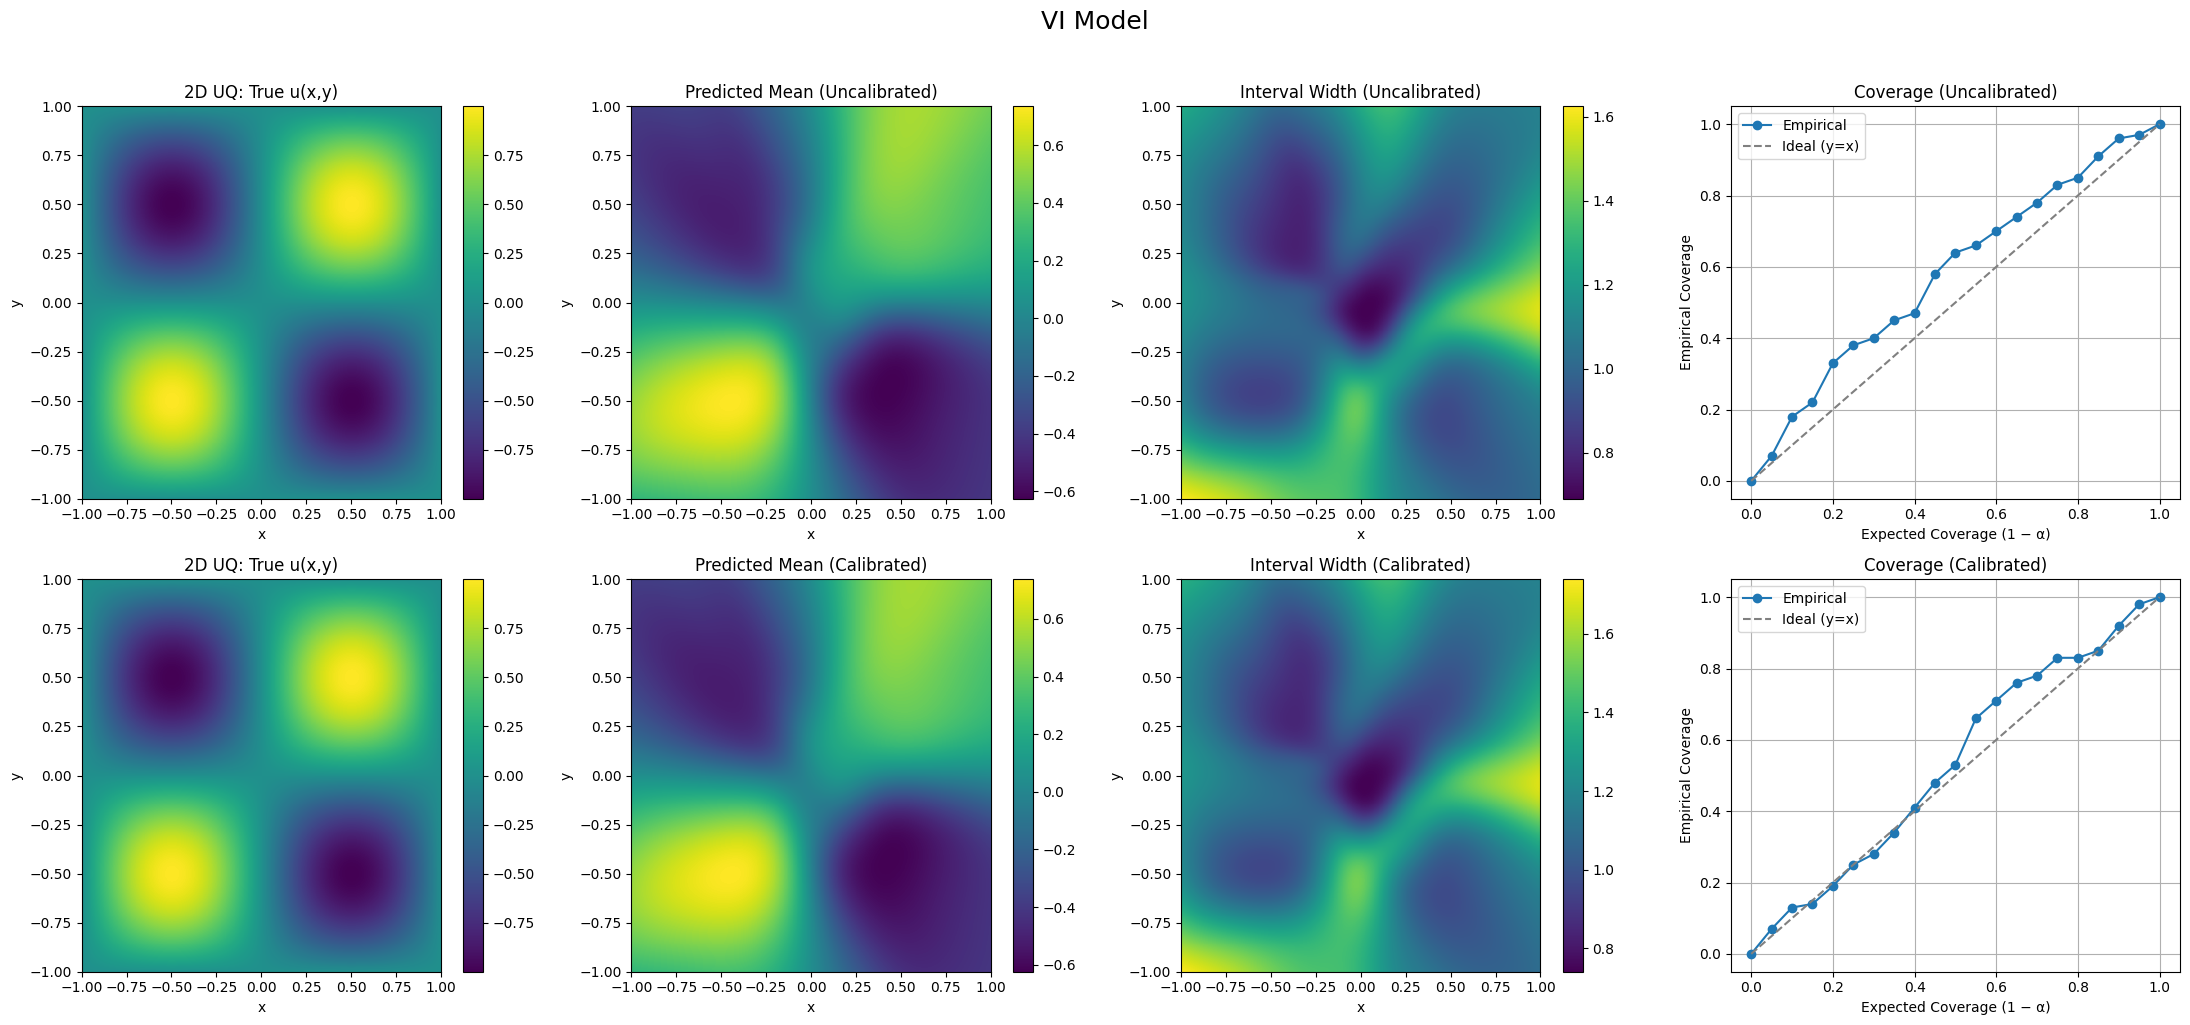

In [ ]:
save_plot(
    plot_2D_comparison_with_coverage,
    save_dir="2D_AllenCahn", prefix="vi_bpinn",
    loss=baseline_data_loss
)(
    grid_test, vi_bpinn_uncal_predset, vi_bpinn_cp_cal_predset, 
    true_solution, 
    vi_bpinn_df_uncal, vi_bpinn_df_cal,
    title="2D UQ", main_title="VI Model", 
    X_vis=X_train, Y_vis=Y_train,
    grid_size=200
)

plot_2D_comparison_with_coverage(
    grid_test, vi_bpinn_uncal_predset, vi_bpinn_cp_cal_predset, 
    true_solution, 
    vi_bpinn_df_uncal, vi_bpinn_df_cal,
    title="2D UQ", main_title="VI Model", 
    X_vis=X_train, Y_vis=Y_train,
    grid_size=200
)


## Plot Coverage Plot

In [31]:
def plot_2D_comparison_with_coverage_new(
    XY_test,
    pred_set_uncal,
    pred_set_cal,
    true_solution,
    df_uncal,
    df_cal,
    X_pts=None,
    X_vis=None, Y_vis=None,
    title="2D UQ Result",
    vlim_true=None,
    vlim_pred_mean=None,
    vlim_pred_width=None,
    show_pts=False,
    alpha_col='alpha',
    cov_col='coverage',
    metric: str = "mae",
    main_title=None,
    grid_size=20,
    *,
    row1_vlim=None,
    row2_vlim=None,
    labels=("Before CP", "After CP"),
    # layout knobs
    middle_col_width=0.039,
    coverage_col_width=1.0,
    wspace=0.13,
    hspace=0.2,
    cb_tick_pad=6,
    cb_tick_size=10,
    width_cmap=my_cmap_2,
    # ===== NEW: grid controls =====
    field_grid=True,                # show grids on the 4 field plots
    field_grid_which="both",         # "major" | "minor" | "both"
    field_grid_color="0.5",
    field_grid_alpha=0.0,
    field_grid_ls=":",
    field_grid_lw=0.6,
    x_major_step=0.35, y_major_step=0.35,
    x_minor_step=0.35, y_minor_step=0.35,
    field_grid_on_top=False,
    # Optional grid on coverage plot
    coverage_grid=True,
    cov_x_major_step=0.2, cov_y_major_step=0.2,
    cov_x_minor_step=0.2, cov_y_minor_step=0.2,
    coverage_grid_which="both",
    fs_cov = 14, 
    fs_fp = 12
):
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    import pandas as pd
    import matplotlib.colors as mcolors
    from matplotlib.cm import ScalarMappable, get_cmap
    from matplotlib.ticker import MultipleLocator, AutoMinorLocator

    # ---------- helpers ----------
    def to_numpy(t):
        if isinstance(t, torch.Tensor):
            return t.detach().cpu().numpy()
        return t

    def prepare_coverage_data(df):
        expected = 1 - df[alpha_col]
        empirical = df[cov_col]
        exp_full = pd.concat([pd.Series([0.0]), expected, pd.Series([1.0])], ignore_index=True)
        emp_full = pd.concat([pd.Series([0.0]), empirical, pd.Series([1.0])], ignore_index=True)
        idx = np.argsort(exp_full.values)
        return exp_full.values[idx], emp_full.values[idx]

    # apply grid styling to an axes
    def _apply_grid(ax, *, which, color, alpha, ls, lw,
                    xmaj, ymaj, xmin, ymin, on_top):
        if xmaj is not None: ax.xaxis.set_major_locator(MultipleLocator(xmaj))
        if ymaj is not None: ax.yaxis.set_major_locator(MultipleLocator(ymaj))
        if xmin is not None: ax.xaxis.set_minor_locator(MultipleLocator(xmin))
        elif which in ("minor", "both"): ax.xaxis.set_minor_locator(AutoMinorLocator())
        if ymin is not None: ax.yaxis.set_minor_locator(MultipleLocator(ymin))
        elif which in ("minor", "both"): ax.yaxis.set_minor_locator(AutoMinorLocator())

        ax.grid(True, which=which, color=color, alpha=alpha, linestyle=ls, linewidth=lw)
        ax.set_axisbelow(not on_top)
        if on_top:
            # draw grid above imshow
            for ln in ax.get_xgridlines() + ax.get_ygridlines():
                ln.set_zorder(3)

    # optional points
    if show_pts:
        if X_vis is not None and Y_vis is not None:
            x_pts = to_numpy(X_vis).flatten(); y_pts = to_numpy(Y_vis).flatten()
        elif X_pts is not None:
            X_pts_np = to_numpy(X_pts); x_pts, y_pts = X_pts_np[:, 0], X_pts_np[:, 1]
        else:
            x_pts = y_pts = None
    else:
        x_pts = y_pts = None

    def add_scatter(ax):
        if x_pts is not None and y_pts is not None:
            ax.scatter(x_pts, y_pts, color='black', s=10, alpha=0.8, label='Sample Points')
            ax.legend(loc='upper right')

    # ---------- grid + fields ----------
    x = to_numpy(XY_test[:, 0]); y = to_numpy(XY_test[:, 1])
    x_lin = np.linspace(x.min(), x.max(), grid_size)
    y_lin = np.linspace(y.min(), y.max(), grid_size)
    X_grid, Y_grid = np.meshgrid(x_lin, y_lin)
    torch_dtype = XY_test.dtype if isinstance(XY_test, torch.Tensor) else torch.float32
    XY_grid = torch.tensor(np.stack([X_grid.ravel(), Y_grid.ravel()], axis=1), dtype=torch_dtype)

    true_grid = to_numpy(true_solution(XY_grid)).reshape(grid_size, grid_size)

    def prep_interval(pred_set):
        lower = to_numpy(pred_set[0]).ravel()
        upper = to_numpy(pred_set[1]).ravel()
        mean  = (lower + upper) / 2.0
        width = upper - lower
        return mean.reshape(grid_size, grid_size), width.reshape(grid_size, grid_size)

    mean_uncal, width_uncal = prep_interval(pred_set_uncal)
    mean_cal,   width_cal   = prep_interval(pred_set_cal)
    pred_mean = mean_uncal

    # ---------- shared vlims ----------
    if row1_vlim is None:
        r1_min = min(true_grid.min(), pred_mean.min())
        r1_max = max(true_grid.max(), pred_mean.max())
        if vlim_true is not None:
            r1_min = min(r1_min, float(vlim_true[0])); r1_max = max(r1_max, float(vlim_true[1]))
        if vlim_pred_mean is not None:
            r1_min = min(r1_min, float(vlim_pred_mean[0])); r1_max = max(r1_max, float(vlim_pred_mean[1]))
        row1_vlim = (r1_min, r1_max)

    if row2_vlim is None:
        if vlim_pred_width is not None:
            row2_vlim = (float(vlim_pred_width[0]), float(vlim_pred_width[1]))
        else:
            row2_vlim = (min(width_uncal.min(), width_cal.min()),
                         max(width_uncal.max(), width_cal.max()))

    extent = [x.min(), x.max(), y.min(), y.max()]
    exp1, emp1 = prepare_coverage_data(df_uncal)
    exp2, emp2 = prepare_coverage_data(df_cal)

    # ---------- figure: 2x4 grid (images + center cbars + right coverage) ----------
    fig = plt.figure(figsize=(22, 10))
    gs = fig.add_gridspec(
        2, 4,
        width_ratios=[1, middle_col_width, 1, coverage_col_width],
        wspace=wspace,
        hspace=hspace
    )

    # image panels
    ax_true = fig.add_subplot(gs[0, 0])
    ax_pred = fig.add_subplot(gs[0, 2])
    ax_wb   = fig.add_subplot(gs[1, 0])
    ax_wa   = fig.add_subplot(gs[1, 2])

    # center colorbar axes
    cax1 = fig.add_subplot(gs[0, 1])
    cax2 = fig.add_subplot(gs[1, 1])

    # coverage (spans both rows)
    ax_cov = fig.add_subplot(gs[:, 3])

    # make image panels ~square
    for ax in (ax_true, ax_pred, ax_wb, ax_wa):
        ax.set_box_aspect(1)

    # Hide duplicate inner y tick labels next to the colorbars
    ax_pred.tick_params(axis='y', labelleft=True)
    ax_wa.tick_params(axis='y', labelleft=True)

    # ----- Row 1: True, Prediction -----
    cmap_row1 = my_cmap  # assumes `my_cmap` exists externally
    im_true = ax_true.imshow(true_grid, extent=extent, origin='lower',
                             aspect='auto', interpolation='bilinear',
                             vmin=row1_vlim[0], vmax=row1_vlim[1], cmap=cmap_row1)
    ax_true.set_title("True Solution"); ax_true.set_ylabel("y",fontsize=fs_fp); add_scatter(ax_true)

    im_pred = ax_pred.imshow(pred_mean, extent=extent, origin='lower',
                             aspect='auto', interpolation='bilinear',
                             vmin=row1_vlim[0], vmax=row1_vlim[1], cmap=cmap_row1)
    ax_pred.set_title("Prediction"); add_scatter(ax_pred)

    # ----- Row 2: Width Before, Width After (different colormap) -----
    cmap_row2 = get_cmap(width_cmap) if isinstance(width_cmap, str) else width_cmap
    im_wb = ax_wb.imshow(width_uncal, extent=extent, origin='lower',
                         aspect='auto', interpolation='bilinear',
                         vmin=row2_vlim[0], vmax=row2_vlim[1], cmap=cmap_row2)
    ax_wb.set_title("Before CP"); ax_wb.set_xlabel("x",fontsize=fs_fp); ax_wb.set_ylabel("y",fontsize=fs_fp); add_scatter(ax_wb)

    im_wa = ax_wa.imshow(width_cal, extent=extent, origin='lower',
                         aspect='auto', interpolation='bilinear',
                         vmin=row2_vlim[0], vmax=row2_vlim[1], cmap=cmap_row2)
    ax_wa.set_title("After CP"); add_scatter(ax_wa); ax_wa.set_xlabel("x",fontsize=fs_fp)

    # ---- Colorbars in middle column (ticks on LEFT; NO labels) ----
    sm1 = ScalarMappable(norm=mcolors.Normalize(vmin=row1_vlim[0], vmax=row1_vlim[1]), cmap=cmap_row1); sm1.set_array([])
    cbar1 = fig.colorbar(sm1, cax=cax1)
    cbar1.ax.tick_params(labelsize=cb_tick_size, pad=cb_tick_pad)
    cbar1.ax.yaxis.set_ticks_position('left'); cbar1.ax.set_ylabel('')

    sm2 = ScalarMappable(norm=mcolors.Normalize(vmin=row2_vlim[0], vmax=row2_vlim[1]), cmap=cmap_row2); sm2.set_array([])
    cbar2 = fig.colorbar(sm2, cax=cax2)
    cbar2.ax.tick_params(labelsize=cb_tick_size, pad=cb_tick_pad)
    cbar2.ax.yaxis.set_ticks_position('left'); cbar2.ax.set_ylabel('')

    # ---- Coverage plot ----
    ax_cov.plot(exp1, emp1, marker='o', linestyle='-', color="#b13c32",
                markerfacecolor="#ed8076", ms=13, lw=5, label=f'{labels[0]}')
    ax_cov.plot(exp2, emp2, marker='*', linestyle='-', color="#3245b1",
                markerfacecolor="#6988ef", ms=20, lw=5, label=f'{labels[1]}')
    ax_cov.plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')
    ax_cov.autoscale(enable=True, tight=False)
    ax_cov.margins(x=0.03, y=0.03)  # 3% padding
    ax_cov.set_aspect('equal', adjustable='box')
    ax_cov.set_xlabel("Expected Coverage (1 − α)",  fontsize=fs_cov)
    ax_cov.set_ylabel("Empirical Coverage",  fontsize=fs_cov)
    if coverage_grid:
        _apply_grid(ax_cov, which=coverage_grid_which, color=field_grid_color, alpha=field_grid_alpha,
                    ls=field_grid_ls, lw=field_grid_lw, on_top=False,
                    xmaj=cov_x_major_step, ymaj=cov_y_major_step,
                    xmin=cov_x_minor_step, ymin=cov_y_minor_step)
    ax_cov.grid(False) if coverage_grid else None
    ax_cov.legend(loc='lower right', fontsize=14)


    # ---- Apply grid to the four field plots (if requested) ----
    if field_grid:
        for ax in (ax_true, ax_pred, ax_wb, ax_wa):
            _apply_grid(ax, which=field_grid_which, color=field_grid_color, alpha=field_grid_alpha,
                        ls=field_grid_ls, lw=field_grid_lw, on_top=field_grid_on_top,
                        xmaj=x_major_step, ymaj=y_major_step,
                        xmin=x_minor_step, ymin=y_minor_step)

    # ---- Two panel tags ----
    posA = ax_true.get_position()
    fig.text(posA.x0 - 0.035, posA.y1 + 0.02, "(A)", ha="left", va="bottom",
             fontsize=15, fontweight="bold")
    posB = ax_cov.get_position()
    fig.text(posB.x0 - 0.030, posB.y1 + 0.02, "(B)", ha="left", va="bottom",
             fontsize=15, fontweight="bold")

    import numpy as np
    axs = np.array([[ax_true, ax_pred], [ax_wb, ax_wa]])
    return fig, axs


In [33]:
save_plot(
    plot_2D_comparison_with_coverage_new,
    save_dir="2D_AllenCahn", prefix="vi_bpinn",
    loss=baseline_data_loss
)(
    grid_test, vi_bpinn_uncal_predset, vi_bpinn_cp_cal_predset, 
    true_solution, 
    vi_bpinn_df_uncal, vi_bpinn_df_cal,
    title="2D UQ", main_title="VI Model", 
    X_vis=X_train, Y_vis=Y_train,
    row1_vlim=(-1, 1),
    row2_vlim=(0, 1.5),
    grid_size=200
    
)

<Figure size 640x480 with 0 Axes>

In [34]:
from utils_tools.utils_result_viz import plot_metrics_table
save_plot(
    plot_metrics_table,
    save_dir="2D_AllenCahn", prefix="vi_bpinn_table",
    loss=baseline_data_loss
)(
    grid_test, vi_bpinn_uncal_predset, vi_bpinn_cp_cal_predset, 
    true_solution, 
    vi_bpinn_df_uncal, vi_bpinn_df_cal,
    title="2D UQ", main_title="VI Model Metrics",
    X_vis=X_train, Y_vis=Y_train
)

Uncal dev:0.0771428525802635
Cal dev:0.03523809303130422


<Figure size 640x480 with 0 Axes>

# HMC Model

## Define Model

In [ ]:
from utils_uqmd.utils_uq_hmc import HMCBPINN

from utils_uqmd.utils_uq_hmc import HMCBPINN

# Base Model Instance
model_args = dict(
    pde_class=pde, input_dim=2, hidden_dims=[16, 32, 64, 64, 64, 32, 16],
    output_dim=1, act_func=nn.Tanh, prior_std=0.60,
)


hmc_bpinn = HMCBPINN(**model_args)

## Training Base Model

In [ ]:
# Base Model
# Training
fit_args = {
    "coloc_pt_num":colloc_pt_num,
    "X_train":X_train, 
    "Y_train":Y_train
}
fit_kwargs_grid = {
    "λ_pde": 1.0,
    "λ_bc": 1.0,
    "λ_data": 1.0,
    "epochs": 500,
    "lr":1e-3,
    "hmc_samples": 6000,
    "brun_in":1000,
    "step_size": 1e-4,
    "leapfrog_steps": 4,
    "lr_decay_step":600, 
    "lr_decay_gamma":0.5
}
baseline_loss_dict = hmc_bpinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = hmc_bpinn.data_loss(X_validation, Y_validation)


MAP:  34%|███▍      | 513/1500 [00:04<00:08, 109.95it/s, loss=1.88e+00]

[MAP] epoch    500 −logPost=2.004e+00  Data=2.46e-01  PDE=5.94e-01  IC=0.00e+00  BC=6.95e-07


MAP:  68%|██████▊   | 1015/1500 [00:09<00:04, 112.90it/s, loss=1.02e+00]

[MAP] epoch   1000 −logPost=1.033e+00  Data=2.46e-01  PDE=5.94e-01  IC=0.00e+00  BC=8.36e-06


[MAP] epoch   1500 −logPost=8.875e-01  Data=2.46e-01  PDE=5.94e-01  IC=0.00e+00  BC=8.56e-06


HMC:   8%|▊         | 504/6000 [00:19<03:28, 26.41it/s, acc=0.78]

[HMC] iter    500  acc-rate=0.78


HMC:  17%|█▋        | 1002/6000 [00:39<03:27, 24.04it/s, acc=0.75]

[HMC] iter   1000  acc-rate=0.75


HMC:  25%|██▌       | 1503/6000 [01:00<03:09, 23.69it/s, acc=0.74]

[HMC] iter   1500  acc-rate=0.74


HMC:  33%|███▎      | 2002/6000 [01:22<02:57, 22.52it/s, acc=0.74]

[HMC] iter   2000  acc-rate=0.74


HMC:  42%|████▏     | 2503/6000 [01:43<02:16, 25.56it/s, acc=0.74]

[HMC] iter   2500  acc-rate=0.74


HMC:  50%|█████     | 3004/6000 [02:03<01:58, 25.34it/s, acc=0.74]

[HMC] iter   3000  acc-rate=0.74


HMC:  58%|█████▊    | 3505/6000 [02:22<01:38, 25.29it/s, acc=0.74]

[HMC] iter   3500  acc-rate=0.74


HMC:  67%|██████▋   | 4003/6000 [02:41<01:22, 24.12it/s, acc=0.74]

[HMC] iter   4000  acc-rate=0.74


HMC:  75%|███████▌  | 4504/6000 [03:01<01:00, 24.65it/s, acc=0.74]

[HMC] iter   4500  acc-rate=0.74


HMC:  83%|████████▎ | 5002/6000 [03:21<00:41, 23.86it/s, acc=0.74]

[HMC] iter   5000  acc-rate=0.74


HMC:  92%|█████████▏| 5503/6000 [03:41<00:19, 25.04it/s, acc=0.74]

[HMC] iter   5500  acc-rate=0.74


[HMC] iter   6000  acc-rate=0.74
Finished HMC: avg acceptance 0.742
Kept 5500 posterior samples


In [ ]:
# Predict 
baseline_pred_kwargs = {"n_samples": 5000}
hmc_bpinn_uncal_predset = hmc_bpinn.predict(
            alpha=alpha, X_test=grid_test,
            **baseline_pred_kwargs
        )

## Create CP Model

In [ ]:
# CP Model
hmc_bpinn_cp = CP(hmc_bpinn)



# CP
cp_pred_kwargs = { 
    "X_train": X_train, "Y_train": Y_train,
    "X_cal": X_calibration, "Y_cal": Y_calibration,
    "heuristic_u": "raw_std", "k": 20
}



hmc_bpinn_cp_cal_predset = hmc_bpinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

In [ ]:
cp_testing_args = {
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":"raw_std", # Change base on if the baseline model has its original uq band
    "k":20
}

baseline_testing_args = {
    # "uqmodel": hmc_model,
    "alphas": alphas,
    "X_test": X_test,
    "Y_test": Y_test,
    "n_samples": 5000
}

# Computing Coverage Info
from utils_tools.utils_result_metrics import hmc_test_uncertainties, cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties, dist_test_uncertainties
hmc_bpinn_df_uncal = hmc_test_uncertainties(uqmodel=hmc_bpinn, **baseline_testing_args)
hmc_bpinn_df_cal = cp_test_uncertainties(hmc_bpinn_cp, **cp_testing_args)

# Save the plot
from utils_tools.utils_tuning import save_plot
from utils_tools.utils_result_viz import plot_2D_comparison_with_coverage
# save_plot(
#     plot_2D_comparison_with_coverage,
#     save_dir="2D_AllenCahn", prefix="hmc_bpinn",
#     loss=baseline_data_loss
# )(
#     grid_test, hmc_bpinn_uncal_predset, hmc_bpinn_cp_cal_predset, 
#     true_solution, 
#     hmc_bpinn_df_uncal, hmc_bpinn_df_cal,
#     title="2D UQ", main_title="HMC Model", 
#     X_vis=X_train, Y_vis=Y_train
# )


  0%|          | 0/19 [00:00<?, ?it/s]/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
100%|██████████| 19/19 [00:57<00:00,  3.03s/it]


## Plot Coverage Plot

In [ ]:
# save_plot(
#     plot_2D_comparison_with_coverage_new,
#     save_dir="2D_AllenCahn", prefix="hmc12_bpinn",
#     loss=baseline_data_loss
# )(
#     grid_test, hmc_bpinn_uncal_predset, hmc_bpinn_cp_cal_predset, 
#     true_solution, 
#     hmc_bpinn_df_uncal, hmc_bpinn_df_cal,
#     title="2D UQ", main_title="HMC Model", 
#     X_vis=X_train, Y_vis=Y_train,
#     row1_vlim=(-1, 1),
#     row2_vlim=(0, 3)
# )

In [ ]:
from utils_tools.utils_result_viz import plot_metrics_table
save_plot(
    plot_metrics_table,
    save_dir="2D_AllenCahn", prefix="hmc_bpinn_table",
    loss=baseline_data_loss
)(
    grid_test, hmc_bpinn_uncal_predset, hmc_bpinn_cp_cal_predset, 
    true_solution, 
    hmc_bpinn_df_uncal, hmc_bpinn_df_cal,
    title="2D UQ", main_title="HMC Model Metrics", 
    X_vis=X_train, Y_vis=Y_train
)

Uncal dev:0.22047619557096845
Cal dev:0.06476189533159846


<Figure size 640x480 with 0 Axes>

# Feature Distance Model

## Define Model

In [ ]:
from utils_uqmd.utils_uq_distance import DistanceUQPINN

# Base-Model Instance
model_args = {
    "pde_class":pde,
    "input_dim":2,
    "hidden_dims":[16, 32, 64, 64, 64, 32, 16], 
    "output_dim":1,
}

# CP-Model

cp_testing_args = {
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":"feature", # Change base on if the baseline cp
    "k":20
}

baseline_testing_args = { 
    # "uqmodel":dist_pinn
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test,
    "heuristic_u":"feature",
    "n_samples":20, 
}

dist_feat_pinn = DistanceUQPINN(**model_args)

## Training Base Model

In [ ]:
# Base Model
# Training
fit_args = dict(
    coloc_pt_num=colloc_pt_num, 
    X_train=X_train, 
    Y_train=Y_train
)
fit_kwargs_grid = dict(
    epochs=5000,
    λ_pde=1.0, λ_ic=5.0, λ_data=1.0,
    lr=1e-3, stop_schedule=20000
)
baseline_loss_dict = dist_feat_pinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = dist_feat_pinn.data_loss(X_validation, Y_validation)


# Predicting
baseline_pred_kwargs = dict(
    n_samples=20, 
    heuristic_u="feature"
)
dist_feat_pinn_uncal_predset = dist_feat_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


ep     1 | L=1.89e+00 | lr=1.0e-03
ep   500 | L=9.77e-02 | lr=1.0e-03
ep  1000 | L=6.50e-02 | lr=1.0e-03
ep  1500 | L=2.65e-02 | lr=1.0e-03
ep  2000 | L=1.91e-02 | lr=1.0e-03
ep  2500 | L=2.20e-02 | lr=1.0e-03
ep  3000 | L=1.50e-02 | lr=1.0e-03
ep  3500 | L=1.06e-02 | lr=1.0e-03
ep  4000 | L=9.05e-03 | lr=1.0e-03
ep  4500 | L=8.12e-03 | lr=1.0e-03
ep  5000 | L=2.34e-02 | lr=1.0e-03


In [ ]:
dist_feat_pinn_uncal_predset = dist_feat_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)

## Create CP Model

In [ ]:
# CP Model
dist_feat_pinn_cp = CP(dist_feat_pinn)

# Predicting
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"feature",  # Change this based on cp
        "k":20
}

dist_feat_pinn_cp_cal_predset = dist_feat_pinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

In [ ]:
# Computing Coverage Info
from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties, dist_test_uncertainties
dist_feat_pinn_df_uncal = dist_test_uncertainties(uqmodel=dist_feat_pinn, **baseline_testing_args)
dist_feat_pinndf_cal = cp_test_uncertainties(dist_feat_pinn_cp, **cp_testing_args)

# Save the plot
from utils_tools.utils_tuning import save_plot
from utils_tools.utils_result_viz import plot_2D_comparison_with_coverage, plot_metrics_table
# save_plot(
#     plot_2D_comparison_with_coverage,
#     save_dir="2D_AllenCahn", prefix="feature_distance",
#     loss=baseline_data_loss
# )(
#     grid_test, dist_feat_pinn_uncal_predset, dist_feat_pinn_cp_cal_predset, 
#     true_solution, 
#     dist_feat_pinn_df_uncal, dist_feat_pinndf_cal,
#     title="2D UQ", main_title="Feature Distance Model", 
#     X_vis=X_train, Y_vis=Y_train
# )



  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:01<00:00, 16.88it/s]


## Plot Coverage Plot

In [ ]:
def plot_2D_comparison_with_coverage_new(
    XY_test,
    pred_set_uncal,
    pred_set_cal,
    true_solution,
    df_uncal,
    df_cal,
    X_pts=None,
    X_vis=None, Y_vis=None,
    title="2D UQ Result",
    vlim_true=None,
    vlim_pred_mean=None,
    vlim_pred_width=None,
    show_pts=False,
    alpha_col='alpha',
    cov_col='coverage',
    metric: str = "mae",
    main_title=None,
    grid_size=200,
    *,
    row1_vlim=None,
    row2_vlim=None,
    labels=("Before CP", "After CP"),
    # layout knobs
    middle_col_width=0.039,
    coverage_col_width=1.0,
    wspace=0.13,
    hspace=0.2,
    cb_tick_pad=6,
    cb_tick_size=10,
    width_cmap=my_cmap_2,
    # ===== NEW: grid controls =====
    field_grid=True,                # show grids on the 4 field plots
    field_grid_which="both",         # "major" | "minor" | "both"
    field_grid_color="0.5",
    field_grid_alpha=0.0,
    field_grid_ls=":",
    field_grid_lw=0.6,
    x_major_step=0.35, y_major_step=0.35,
    x_minor_step=0.35, y_minor_step=0.35,
    field_grid_on_top=False,
    # Optional grid on coverage plot
    coverage_grid=True,
    cov_x_major_step=0.2, cov_y_major_step=0.2,
    cov_x_minor_step=0.2, cov_y_minor_step=0.2,
    coverage_grid_which="both",
    fs_cov = 14, 
    fs_fp = 12
):
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    import pandas as pd
    import matplotlib.colors as mcolors
    from matplotlib.cm import ScalarMappable, get_cmap
    from matplotlib.ticker import MultipleLocator, AutoMinorLocator

    # ---------- helpers ----------
    def to_numpy(t):
        if isinstance(t, torch.Tensor):
            return t.detach().cpu().numpy()
        return t

    def prepare_coverage_data(df):
        expected = 1 - df[alpha_col]
        empirical = df[cov_col]
        exp_full = pd.concat([pd.Series([0.0]), expected, pd.Series([1.0])], ignore_index=True)
        emp_full = pd.concat([pd.Series([0.0]), empirical, pd.Series([1.0])], ignore_index=True)
        idx = np.argsort(exp_full.values)
        return exp_full.values[idx], emp_full.values[idx]

    # apply grid styling to an axes
    def _apply_grid(ax, *, which, color, alpha, ls, lw,
                    xmaj, ymaj, xmin, ymin, on_top):
        if xmaj is not None: ax.xaxis.set_major_locator(MultipleLocator(xmaj))
        if ymaj is not None: ax.yaxis.set_major_locator(MultipleLocator(ymaj))
        if xmin is not None: ax.xaxis.set_minor_locator(MultipleLocator(xmin))
        elif which in ("minor", "both"): ax.xaxis.set_minor_locator(AutoMinorLocator())
        if ymin is not None: ax.yaxis.set_minor_locator(MultipleLocator(ymin))
        elif which in ("minor", "both"): ax.yaxis.set_minor_locator(AutoMinorLocator())

        ax.grid(True, which=which, color=color, alpha=alpha, linestyle=ls, linewidth=lw)
        ax.set_axisbelow(not on_top)
        if on_top:
            # draw grid above imshow
            for ln in ax.get_xgridlines() + ax.get_ygridlines():
                ln.set_zorder(3)

    # optional points
    if show_pts:
        if X_vis is not None and Y_vis is not None:
            x_pts = to_numpy(X_vis).flatten(); y_pts = to_numpy(Y_vis).flatten()
        elif X_pts is not None:
            X_pts_np = to_numpy(X_pts); x_pts, y_pts = X_pts_np[:, 0], X_pts_np[:, 1]
        else:
            x_pts = y_pts = None
    else:
        x_pts = y_pts = None

    def add_scatter(ax):
        if x_pts is not None and y_pts is not None:
            ax.scatter(x_pts, y_pts, color='black', s=10, alpha=0.8, label='Sample Points')
            ax.legend(loc='upper right')

    # ---------- grid + fields ----------
    x = to_numpy(XY_test[:, 0]); y = to_numpy(XY_test[:, 1])
    x_lin = np.linspace(x.min(), x.max(), grid_size)
    y_lin = np.linspace(y.min(), y.max(), grid_size)
    X_grid, Y_grid = np.meshgrid(x_lin, y_lin)
    torch_dtype = XY_test.dtype if isinstance(XY_test, torch.Tensor) else torch.float32
    XY_grid = torch.tensor(np.stack([X_grid.ravel(), Y_grid.ravel()], axis=1), dtype=torch_dtype)

    true_grid = to_numpy(true_solution(XY_grid)).reshape(grid_size, grid_size)

    def prep_interval(pred_set):
        lower = to_numpy(pred_set[0]).ravel()
        upper = to_numpy(pred_set[1]).ravel()
        mean  = (lower + upper) / 2.0
        width = upper - lower
        return mean.reshape(grid_size, grid_size), width.reshape(grid_size, grid_size)

    mean_uncal, width_uncal = prep_interval(pred_set_uncal)
    mean_cal,   width_cal   = prep_interval(pred_set_cal)
    pred_mean = mean_uncal

    # ---------- shared vlims ----------
    if row1_vlim is None:
        r1_min = min(true_grid.min(), pred_mean.min())
        r1_max = max(true_grid.max(), pred_mean.max())
        if vlim_true is not None:
            r1_min = min(r1_min, float(vlim_true[0])); r1_max = max(r1_max, float(vlim_true[1]))
        if vlim_pred_mean is not None:
            r1_min = min(r1_min, float(vlim_pred_mean[0])); r1_max = max(r1_max, float(vlim_pred_mean[1]))
        row1_vlim = (r1_min, r1_max)

    if row2_vlim is None:
        if vlim_pred_width is not None:
            row2_vlim = (float(vlim_pred_width[0]), float(vlim_pred_width[1]))
        else:
            row2_vlim = (min(width_uncal.min(), width_cal.min()),
                         max(width_uncal.max(), width_cal.max()))

    extent = [x.min(), x.max(), y.min(), y.max()]
    exp1, emp1 = prepare_coverage_data(df_uncal)
    exp2, emp2 = prepare_coverage_data(df_cal)

    # ---------- figure: 2x4 grid (images + center cbars + right coverage) ----------
    fig = plt.figure(figsize=(22, 10))
    gs = fig.add_gridspec(
        2, 4,
        width_ratios=[1, middle_col_width, 1, coverage_col_width],
        wspace=wspace,
        hspace=hspace
    )

    # image panels
    ax_true = fig.add_subplot(gs[0, 0])
    ax_pred = fig.add_subplot(gs[0, 2])
    ax_wb   = fig.add_subplot(gs[1, 0])
    ax_wa   = fig.add_subplot(gs[1, 2])

    # center colorbar axes
    cax1 = fig.add_subplot(gs[0, 1])
    cax2 = fig.add_subplot(gs[1, 1])

    # coverage (spans both rows)
    ax_cov = fig.add_subplot(gs[:, 3])

    # make image panels ~square
    for ax in (ax_true, ax_pred, ax_wb, ax_wa):
        ax.set_box_aspect(1)

    # Hide duplicate inner y tick labels next to the colorbars
    ax_pred.tick_params(axis='y', labelleft=True)
    ax_wa.tick_params(axis='y', labelleft=True)

    # ----- Row 1: True, Prediction -----
    cmap_row1 = my_cmap  # assumes `my_cmap` exists externally
    im_true = ax_true.imshow(true_grid, extent=extent, origin='lower',
                             aspect='auto', interpolation='bilinear',
                             vmin=row1_vlim[0], vmax=row1_vlim[1], cmap=cmap_row1)
    ax_true.set_title("True Solution"); ax_true.set_ylabel("y",fontsize=fs_fp); add_scatter(ax_true)

    im_pred = ax_pred.imshow(pred_mean, extent=extent, origin='lower',
                             aspect='auto', interpolation='bilinear',
                             vmin=row1_vlim[0], vmax=row1_vlim[1], cmap=cmap_row1)
    ax_pred.set_title("Prediction"); add_scatter(ax_pred)

    # ----- Row 2: Width Before, Width After (different colormap) -----
    cmap_row2 = get_cmap(width_cmap) if isinstance(width_cmap, str) else width_cmap
    im_wb = ax_wb.imshow(width_uncal, extent=extent, origin='lower',
                         aspect='auto', interpolation='bilinear',
                         vmin=row2_vlim[0], vmax=row2_vlim[1], cmap=cmap_row2)
    ax_wb.set_title("Before CP"); ax_wb.set_xlabel("x",fontsize=fs_fp); ax_wb.set_ylabel("y",fontsize=fs_fp); add_scatter(ax_wb)

    im_wa = ax_wa.imshow(width_cal, extent=extent, origin='lower',
                         aspect='auto', interpolation='bilinear',
                         vmin=row2_vlim[0], vmax=row2_vlim[1], cmap=cmap_row2)
    ax_wa.set_title("After CP"); add_scatter(ax_wa); ax_wa.set_xlabel("x",fontsize=fs_fp)

    # ---- Colorbars in middle column (ticks on LEFT; NO labels) ----
    sm1 = ScalarMappable(norm=mcolors.Normalize(vmin=row1_vlim[0], vmax=row1_vlim[1]), cmap=cmap_row1); sm1.set_array([])
    cbar1 = fig.colorbar(sm1, cax=cax1)
    cbar1.ax.tick_params(labelsize=cb_tick_size, pad=cb_tick_pad)
    cbar1.ax.yaxis.set_ticks_position('left'); cbar1.ax.set_ylabel('')

    sm2 = ScalarMappable(norm=mcolors.Normalize(vmin=row2_vlim[0], vmax=row2_vlim[1]), cmap=cmap_row2); sm2.set_array([])
    cbar2 = fig.colorbar(sm2, cax=cax2)
    cbar2.ax.tick_params(labelsize=cb_tick_size, pad=cb_tick_pad)
    cbar2.ax.yaxis.set_ticks_position('left'); cbar2.ax.set_ylabel('')

    # ---- Coverage plot ----
    ax_cov.plot(exp1, emp1, marker='o', linestyle='-', color="#b13c32",
                markerfacecolor="#ed8076", ms=13, lw=5, label=f'{labels[0]}')
    ax_cov.plot(exp2, emp2, marker='*', linestyle='-', color="#3245b1",
                markerfacecolor="#6988ef", ms=20, lw=5, label=f'{labels[1]}')
    ax_cov.plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')
    ax_cov.autoscale(enable=True, tight=False)
    ax_cov.margins(x=0.03, y=0.03)  # 3% padding
    ax_cov.set_aspect('equal', adjustable='box')
    ax_cov.set_xlabel("Expected Coverage (1 − α)",  fontsize=fs_cov)
    ax_cov.set_ylabel("Empirical Coverage",  fontsize=fs_cov)
    if coverage_grid:
        _apply_grid(ax_cov, which=coverage_grid_which, color=field_grid_color, alpha=field_grid_alpha,
                    ls=field_grid_ls, lw=field_grid_lw, on_top=False,
                    xmaj=cov_x_major_step, ymaj=cov_y_major_step,
                    xmin=cov_x_minor_step, ymin=cov_y_minor_step)
    ax_cov.grid(False) if coverage_grid else None
    ax_cov.legend(loc='lower right', fontsize=14)


    # ---- Apply grid to the four field plots (if requested) ----
    if field_grid:
        for ax in (ax_true, ax_pred, ax_wb, ax_wa):
            _apply_grid(ax, which=field_grid_which, color=field_grid_color, alpha=field_grid_alpha,
                        ls=field_grid_ls, lw=field_grid_lw, on_top=field_grid_on_top,
                        xmaj=x_major_step, ymaj=y_major_step,
                        xmin=x_minor_step, ymin=y_minor_step)

    # ---- Two panel tags ----
    posA = ax_true.get_position()
    fig.text(posA.x0 - 0.035, posA.y1 + 0.02, "(A)", ha="left", va="bottom",
             fontsize=15, fontweight="bold")
    posB = ax_cov.get_position()
    fig.text(posB.x0 - 0.030, posB.y1 + 0.02, "(B)", ha="left", va="bottom",
             fontsize=15, fontweight="bold")

    import numpy as np
    axs = np.array([[ax_true, ax_pred], [ax_wb, ax_wa]])
    return fig, axs


In [ ]:
def plot_2D_comparison_with_coverage_with_error(
    XY_test,
    pred_set_uncal,
    pred_set_cal,
    true_solution,
    df_uncal,
    df_cal,
    X_pts=None,
    X_vis=None, Y_vis=None,
    title="2D UQ Result",
    vlim_true=None,
    vlim_pred_mean=None,
    vlim_pred_width=None,
    show_pts=False,
    alpha_col='alpha',
    cov_col='coverage',
    metric: str = "mae",
    main_title=None,
    grid_size=20,
    *,
    row1_vlim=None,
    row2_vlim=None,
    labels=("Before CP", "After CP"),
    # layout knobs
    middle_col_width=0.039,
    coverage_col_width=1.0,
    wspace=0.13,
    hspace=0.2,
    cb_tick_pad=6,
    cb_tick_size=10,
    width_cmap=my_cmap_2,
    # ===== NEW: grid controls =====
    field_grid=True,                # show grids on the 4 field plots
    field_grid_which="both",         # "major" | "minor" | "both"
    field_grid_color="0.5",
    field_grid_alpha=0.0,
    field_grid_ls=":",
    field_grid_lw=0.6,
    x_major_step=0.35, y_major_step=0.35,
    x_minor_step=0.35, y_minor_step=0.35,
    field_grid_on_top=False,
    # Optional grid on coverage plot
    coverage_grid=True,
    cov_x_major_step=0.2, cov_y_major_step=0.2,
    cov_x_minor_step=0.2, cov_y_minor_step=0.2,
    coverage_grid_which="both",
    fs_cov = 14, 
    fs_fp = 12
):
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    import pandas as pd
    import matplotlib.colors as mcolors
    from matplotlib.cm import ScalarMappable, get_cmap
    from matplotlib.ticker import MultipleLocator, AutoMinorLocator

    # ---------- helpers ----------
    def to_numpy(t):
        if isinstance(t, torch.Tensor):
            return t.detach().cpu().numpy()
        return t

    def prepare_coverage_data(df):
        expected = 1 - df[alpha_col]
        empirical = df[cov_col]
        exp_full = pd.concat([pd.Series([0.0]), expected, pd.Series([1.0])], ignore_index=True)
        emp_full = pd.concat([pd.Series([0.0]), empirical, pd.Series([1.0])], ignore_index=True)
        idx = np.argsort(exp_full.values)
        return exp_full.values[idx], emp_full.values[idx]

    # apply grid styling to an axes
    def _apply_grid(ax, *, which, color, alpha, ls, lw,
                    xmaj, ymaj, xmin, ymin, on_top):
        if xmaj is not None: ax.xaxis.set_major_locator(MultipleLocator(xmaj))
        if ymaj is not None: ax.yaxis.set_major_locator(MultipleLocator(ymaj))
        if xmin is not None: ax.xaxis.set_minor_locator(MultipleLocator(xmin))
        elif which in ("minor", "both"): ax.xaxis.set_minor_locator(AutoMinorLocator())
        if ymin is not None: ax.yaxis.set_minor_locator(MultipleLocator(ymin))
        elif which in ("minor", "both"): ax.yaxis.set_minor_locator(AutoMinorLocator())

        ax.grid(True, which=which, color=color, alpha=alpha, linestyle=ls, linewidth=lw)
        ax.set_axisbelow(not on_top)
        if on_top:
            # draw grid above imshow
            for ln in ax.get_xgridlines() + ax.get_ygridlines():
                ln.set_zorder(3)

    # optional points
    if show_pts:
        if X_vis is not None and Y_vis is not None:
            x_pts = to_numpy(X_vis).flatten(); y_pts = to_numpy(Y_vis).flatten()
        elif X_pts is not None:
            X_pts_np = to_numpy(X_pts); x_pts, y_pts = X_pts_np[:, 0], X_pts_np[:, 1]
        else:
            x_pts = y_pts = None
    else:
        x_pts = y_pts = None

    def add_scatter(ax):
        if x_pts is not None and y_pts is not None:
            ax.scatter(x_pts, y_pts, color='black', s=10, alpha=0.8, label='Sample Points')
            ax.legend(loc='upper right')

    # ---------- grid + fields ----------
    x = to_numpy(XY_test[:, 0]); y = to_numpy(XY_test[:, 1])
    x_lin = np.linspace(x.min(), x.max(), grid_size)
    y_lin = np.linspace(y.min(), y.max(), grid_size)
    X_grid, Y_grid = np.meshgrid(x_lin, y_lin)
    torch_dtype = XY_test.dtype if isinstance(XY_test, torch.Tensor) else torch.float32
    XY_grid = torch.tensor(np.stack([X_grid.ravel(), Y_grid.ravel()], axis=1), dtype=torch_dtype)

    true_grid = to_numpy(true_solution(XY_grid)).reshape(grid_size, grid_size)

    def prep_interval(pred_set):
        lower = to_numpy(pred_set[0]).ravel()
        upper = to_numpy(pred_set[1]).ravel()
        mean  = (lower + upper) / 2.0
        width = upper - lower
        return mean.reshape(grid_size, grid_size), width.reshape(grid_size, grid_size)

    mean_uncal, width_uncal = prep_interval(pred_set_uncal)
    mean_cal,   width_cal   = prep_interval(pred_set_cal)
    pred_mean = mean_uncal

    # ---------- shared vlims ----------
    if row1_vlim is None:
        r1_min = min(true_grid.min(), pred_mean.min())
        r1_max = max(true_grid.max(), pred_mean.max())
        if vlim_true is not None:
            r1_min = min(r1_min, float(vlim_true[0])); r1_max = max(r1_max, float(vlim_true[1]))
        if vlim_pred_mean is not None:
            r1_min = min(r1_min, float(vlim_pred_mean[0])); r1_max = max(r1_max, float(vlim_pred_mean[1]))
        row1_vlim = (r1_min, r1_max)

    if row2_vlim is None:
        if vlim_pred_width is not None:
            row2_vlim = (float(vlim_pred_width[0]), float(vlim_pred_width[1]))
        else:
            row2_vlim = (min(width_uncal.min(), width_cal.min()),
                         max(width_uncal.max(), width_cal.max()))

    extent = [x.min(), x.max(), y.min(), y.max()]
    exp1, emp1 = prepare_coverage_data(df_uncal)
    exp2, emp2 = prepare_coverage_data(df_cal)

    # ---------- figure: 2x4 grid (images + center cbars + right coverage) ----------
    fig = plt.figure(figsize=(22, 10))
    gs = fig.add_gridspec(
        2, 4,
        width_ratios=[1, middle_col_width, 1, coverage_col_width],
        wspace=wspace,
        hspace=hspace
    )

    # image panels
    ax_true = fig.add_subplot(gs[0, 0])
    ax_pred = fig.add_subplot(gs[0, 2])
    ax_wb   = fig.add_subplot(gs[1, 0])
    ax_wa   = fig.add_subplot(gs[1, 2])

    # center colorbar axes
    cax1 = fig.add_subplot(gs[0, 1])
    cax2 = fig.add_subplot(gs[1, 1])

    # coverage (spans both rows)
    ax_cov = fig.add_subplot(gs[:, 3])

    # make image panels ~square
    for ax in (ax_true, ax_pred, ax_wb, ax_wa):
        ax.set_box_aspect(1)

    # Hide duplicate inner y tick labels next to the colorbars
    ax_pred.tick_params(axis='y', labelleft=True)
    ax_wa.tick_params(axis='y', labelleft=True)

    # ----- Row 1: True, Prediction -----
    cmap_row1 = my_cmap  # assumes `my_cmap` exists externally
    im_true = ax_true.imshow(true_grid, extent=extent, origin='lower',
                             aspect='auto', interpolation='bilinear',
                             vmin=row1_vlim[0], vmax=row1_vlim[1], cmap=cmap_row1)
    ax_true.set_title("True Solution"); ax_true.set_ylabel("y",fontsize=fs_fp); add_scatter(ax_true)

    im_pred = ax_pred.imshow(pred_mean, extent=extent, origin='lower',
                             aspect='auto', interpolation='bilinear',
                             vmin=row1_vlim[0], vmax=row1_vlim[1], cmap=cmap_row1)
    ax_pred.set_title("Prediction"); add_scatter(ax_pred)

    # ----- Row 2: Width Before, Width After (different colormap) -----
    cmap_row2 = get_cmap(width_cmap) if isinstance(width_cmap, str) else width_cmap
    im_wb = ax_wb.imshow(width_uncal, extent=extent, origin='lower',
                         aspect='auto', interpolation='bilinear',
                         vmin=row2_vlim[0], vmax=row2_vlim[1], cmap=cmap_row2)
    ax_wb.set_title("Before CP"); ax_wb.set_xlabel("x",fontsize=fs_fp); ax_wb.set_ylabel("y",fontsize=fs_fp); add_scatter(ax_wb)

    im_wa = ax_wa.imshow(width_cal, extent=extent, origin='lower',
                         aspect='auto', interpolation='bilinear',
                         vmin=row2_vlim[0], vmax=row2_vlim[1], cmap=cmap_row2)
    ax_wa.set_title("After CP"); add_scatter(ax_wa); ax_wa.set_xlabel("x",fontsize=fs_fp)

    # ---- Colorbars in middle column (ticks on LEFT; NO labels) ----
    sm1 = ScalarMappable(norm=mcolors.Normalize(vmin=row1_vlim[0], vmax=row1_vlim[1]), cmap=cmap_row1); sm1.set_array([])
    cbar1 = fig.colorbar(sm1, cax=cax1)
    cbar1.ax.tick_params(labelsize=cb_tick_size, pad=cb_tick_pad)
    cbar1.ax.yaxis.set_ticks_position('left'); cbar1.ax.set_ylabel('')

    sm2 = ScalarMappable(norm=mcolors.Normalize(vmin=row2_vlim[0], vmax=row2_vlim[1]), cmap=cmap_row2); sm2.set_array([])
    cbar2 = fig.colorbar(sm2, cax=cax2)
    cbar2.ax.tick_params(labelsize=cb_tick_size, pad=cb_tick_pad)
    cbar2.ax.yaxis.set_ticks_position('left'); cbar2.ax.set_ylabel('')

    # ---- Coverage plot ----
    ax_cov.plot(exp1, emp1, marker='o', linestyle='-', color="#b13c32",
                markerfacecolor="#ed8076", ms=13, lw=5, label=f'{labels[0]}')
    ax_cov.plot(exp2, emp2, marker='*', linestyle='-', color="#3245b1",
                markerfacecolor="#6988ef", ms=20, lw=5, label=f'{labels[1]}')
    ax_cov.plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')
    ax_cov.autoscale(enable=True, tight=False)
    ax_cov.margins(x=0.03, y=0.03)  # 3% padding
    ax_cov.set_aspect('equal', adjustable='box')
    ax_cov.set_xlabel("Expected Coverage (1 − α)",  fontsize=fs_cov)
    ax_cov.set_ylabel("Empirical Coverage",  fontsize=fs_cov)
    if coverage_grid:
        _apply_grid(ax_cov, which=coverage_grid_which, color=field_grid_color, alpha=field_grid_alpha,
                    ls=field_grid_ls, lw=field_grid_lw, on_top=False,
                    xmaj=cov_x_major_step, ymaj=cov_y_major_step,
                    xmin=cov_x_minor_step, ymin=cov_y_minor_step)
    ax_cov.grid(False) if coverage_grid else None
    ax_cov.legend(loc='lower right', fontsize=14)


    # ---- Apply grid to the four field plots (if requested) ----
    if field_grid:
        for ax in (ax_true, ax_pred, ax_wb, ax_wa):
            _apply_grid(ax, which=field_grid_which, color=field_grid_color, alpha=field_grid_alpha,
                        ls=field_grid_ls, lw=field_grid_lw, on_top=field_grid_on_top,
                        xmaj=x_major_step, ymaj=y_major_step,
                        xmin=x_minor_step, ymin=y_minor_step)

    # ---- Two panel tags ----
    posA = ax_true.get_position()
    fig.text(posA.x0 - 0.035, posA.y1 + 0.02, "(A)", ha="left", va="bottom",
             fontsize=15, fontweight="bold")
    posB = ax_cov.get_position()
    fig.text(posB.x0 - 0.030, posB.y1 + 0.02, "(B)", ha="left", va="bottom",
             fontsize=15, fontweight="bold")

    import numpy as np
    axs = np.array([[ax_true, ax_pred], [ax_wb, ax_wa]])
    return fig, axs


In [ ]:
save_plot(
    plot_2D_comparison_with_coverage_new,
    save_dir="2D_AllenCahn", 
    prefix="feature_distance", #<--
    loss=baseline_data_loss
)(
    grid_test, 
    dist_feat_pinn_uncal_predset, #<--
    dist_feat_pinn_cp_cal_predset, #<--
    true_solution, 
    dist_feat_pinn_df_uncal, #<--
    dist_feat_pinndf_cal, #<--
    title="2D UQ", 
    main_title="Feature Distance Model", #<--
    X_vis=X_train, Y_vis=Y_train,
    row1_vlim=(-1, 1),
    row2_vlim=(0, 1.5)
)

<Figure size 640x480 with 0 Axes>

In [ ]:
save_plot(
    plot_metrics_table,
    save_dir="2D_AllenCahn", prefix="feature_distance_table",
    loss=baseline_data_loss
)(
    grid_test, dist_feat_pinn_uncal_predset, dist_feat_pinn_cp_cal_predset, 
    true_solution, 
    dist_feat_pinn_df_uncal, dist_feat_pinndf_cal,
    title="2D UQ", main_title="Feature Distance Model Metrics", 
    X_vis=X_train, Y_vis=Y_train
)

Uncal dev:0.31761904681722325
Cal dev:0.03047619777775946


<Figure size 640x480 with 0 Axes>

## Separate Plot

### Coverage Comparison Plot

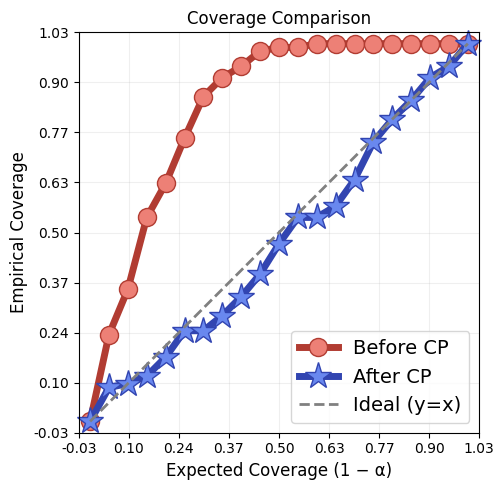

<Figure size 640x480 with 0 Axes>

In [ ]:
ax_info = plot_coverage_comparison(
    df_uncal = dist_feat_pinn_df_uncal, # <--
    df_cal = dist_feat_pinndf_cal, # <--
    labels=("Before CP", "After CP")
)

save_plot(
    plot_coverage_comparison,
    save_dir="2DAllenCahn/FD", # <--
    prefix="coverage_comparison", # <--
    loss=baseline_data_loss
)(
    df_uncal = dist_feat_pinn_df_uncal, # <--
    df_cal = dist_feat_pinndf_cal, # <--
    labels=("Before CP", "After CP")
)

### 1st Row 

#### True Solution

/var/folders/nk/7m8bs7zj68dcqhl1g64gcwh80000gn/T/ipykernel_85964/2853600904.py:172: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


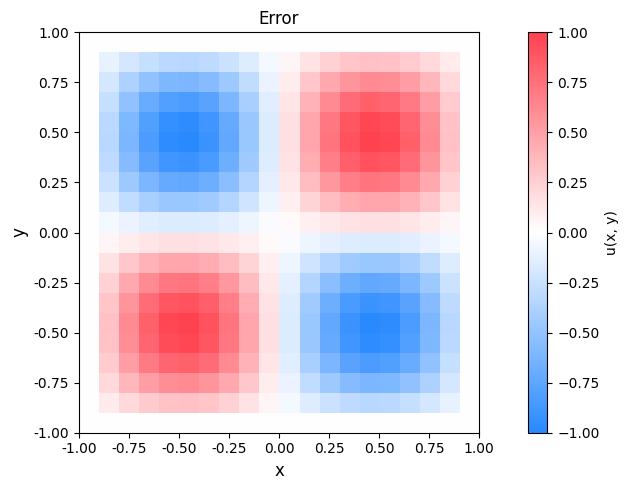

<Figure size 640x480 with 0 Axes>

In [ ]:
vlim_mean = (-1.0, 1.0)
cbar_kwargs = {"ticks": np.linspace(-1.0, 1.5, 10), "format": "%.2f"}
fig, ax, field = plot_uq_field(
    grid_test, true_solution, dist_feat_pinn_uncal_predset, mode="true",
    vlim=vlim_mean,
    title="Error",
    match_to_ax=ax_info,          # <<— exact axes-size match
    n_ticks=9, font_size=12, tick_size=10,
)


save_plot(
    plot_uq_field,
    save_dir="2DAllenCahn/FD", # <--
    prefix="true_soln", # <--
    loss=baseline_data_loss
)(
    grid_test, pde.true_solution, 
    dist_feat_pinn_uncal_predset, # <--
    mode="true",
    vlim=vlim_mean, cbar_kwargs=cbar_kwargs, title="True Solution"
)

#### Prediction

/var/folders/nk/7m8bs7zj68dcqhl1g64gcwh80000gn/T/ipykernel_85964/2853600904.py:172: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


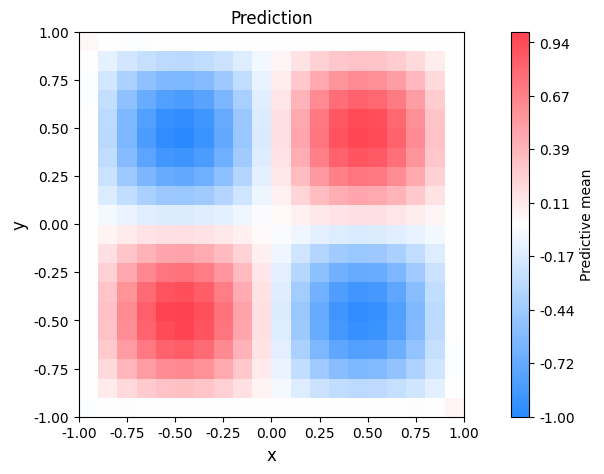

<Figure size 640x480 with 0 Axes>

In [ ]:
cbar_kwargs = {"ticks": np.linspace(-1.0, 1.5, 10), "format": "%.2f"}
fig, ax, field = plot_uq_field(grid_test, pde.true_solution, dist_feat_pinn_cp_cal_predset, mode="mean",
                               vlim=vlim_mean, cbar_kwargs=cbar_kwargs, title="Prediction")


save_plot(
    plot_uq_field,
    save_dir="2DAllenCahn/FD", # <--
    prefix="prediction", # <--
    loss=baseline_data_loss
)(
    grid_test, pde.true_solution, 
    dist_feat_pinn_cp_cal_predset, # <--
    mode="mean",
    vlim=vlim_mean, cbar_kwargs=cbar_kwargs, title="Prediction"
)

#### Error

/var/folders/nk/7m8bs7zj68dcqhl1g64gcwh80000gn/T/ipykernel_85964/2853600904.py:172: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


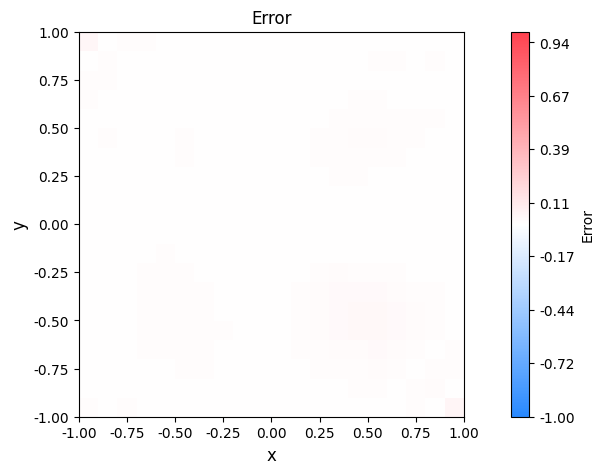

<Figure size 640x480 with 0 Axes>

In [ ]:
vlim_mean = (-1.0, 1.0)
fig, ax, field = plot_uq_field(grid_test, pde.true_solution, dist_feat_pinn_cp_cal_predset, mode="diff",
                               vlim=vlim_mean, cbar_kwargs=cbar_kwargs, title="Error")


save_plot(
    plot_uq_field,
    save_dir="2DAllenCahn/FD", # <--
    prefix="error", # <--
    loss=baseline_data_loss
)(
    grid_test, pde.true_solution, 
    dist_feat_pinn_cp_cal_predset, # <--
    mode="diff",
    vlim=vlim_mean, cbar_kwargs=cbar_kwargs, title="Error"
)

### 2nd Row 

#### Width Before CP

/var/folders/nk/7m8bs7zj68dcqhl1g64gcwh80000gn/T/ipykernel_85964/2853600904.py:172: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


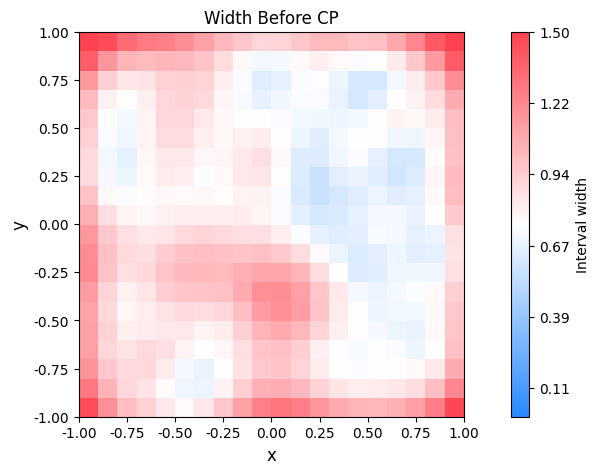

<Figure size 640x480 with 0 Axes>

In [ ]:
vlim_mean = (0, 1.5)
fig, ax, field = plot_uq_field(grid_test, pde.true_solution, dist_feat_pinn_uncal_predset, mode="width",
                               vlim=vlim_mean, cbar_kwargs=cbar_kwargs, title="Width Before CP")


save_plot(
    plot_uq_field,
    save_dir="2DAllenCahn/FD", # <--
    prefix="width_before_CP", # <--
    loss=baseline_data_loss
)(
    grid_test, pde.true_solution, 
    dist_feat_pinn_uncal_predset,  # <--
    mode="width",
    vlim=vlim_mean, cbar_kwargs=cbar_kwargs, title="Width Before CP"
)

#### Width After CP

/var/folders/nk/7m8bs7zj68dcqhl1g64gcwh80000gn/T/ipykernel_85964/2853600904.py:172: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


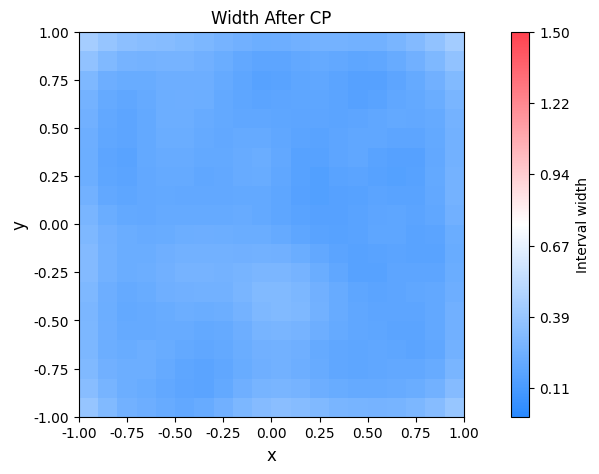

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, ax, field = plot_uq_field(grid_test, pde.true_solution, dist_feat_pinn_cp_cal_predset, mode="width",
                               vlim=vlim_mean, cbar_kwargs=cbar_kwargs, title="Width After CP")


save_plot(
    plot_uq_field,
    save_dir="2DAllenCahn/FD", # <--
    prefix="width_after_cp", # <--
    loss=baseline_data_loss
)(
    grid_test, pde.true_solution, 
    dist_feat_pinn_cp_cal_predset,  # <--
    mode="width",
    vlim=vlim_mean, cbar_kwargs=cbar_kwargs, title="Width After CP"
)

# Latent Distance Model

## Define Model

In [ ]:
from utils_uqmd.utils_uq_distance import DistanceUQPINN

# Base-Model Instance
model_args = {
    "pde_class":pde,
    "input_dim":2,
    "hidden_dims":[16, 32, 64, 64, 64, 32, 16], 
    "output_dim":1,
}

baseline_pred_kwargs = dict(n_samples=200)


# CP-Model

cp_testing_args = {
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":"latent", # Change base on if the baseline cp
    "k":20
}

baseline_testing_args = { 
    # "uqmodel":dist_pinn
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test,
    "heuristic_u":"latent",
    "n_samples":20, 
}

dist_lat_pinn = DistanceUQPINN(**model_args)

## Training Base Model

In [ ]:
# Base Model
# Training
fit_args = dict(
    coloc_pt_num=colloc_pt_num, 
    X_train=X_train, 
    Y_train=Y_train
)
fit_kwargs_grid = dict(
    epochs=5000,
    λ_pde=1.0, λ_ic=5.0, λ_data=1.0,
    lr=1e-3, stop_schedule=20000
)
baseline_loss_dict = dist_lat_pinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = dist_lat_pinn.data_loss(X_validation, Y_validation)


# Predicting
baseline_pred_kwargs = dict(
    n_samples=20, 
    heuristic_u="latent"
)
dist_lat_pinn_uncal_predset = dist_lat_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


ep     1 | L=1.21e+00 | lr=1.0e-03
ep   500 | L=1.11e-01 | lr=1.0e-03
ep  1000 | L=9.89e-02 | lr=1.0e-03
ep  1500 | L=4.16e-02 | lr=1.0e-03
ep  2000 | L=3.62e-02 | lr=1.0e-03
ep  2500 | L=2.29e-02 | lr=1.0e-03
ep  3000 | L=2.03e-02 | lr=1.0e-03
ep  3500 | L=1.24e-02 | lr=1.0e-03
ep  4000 | L=1.18e-02 | lr=1.0e-03
ep  4500 | L=1.62e-02 | lr=1.0e-03
ep  5000 | L=8.46e-03 | lr=1.0e-03


## Create CP Model

In [ ]:
# CP Model
dist_lat_pinn_cp = CP(dist_lat_pinn)

# Predicting
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"latent",  # Change this based on cp
        "k":20
}

dist_lat_pinn_cp_cal_predset = dist_lat_pinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

In [ ]:
# Computing Coverage Info
from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties, dist_test_uncertainties
dist_lat_pinn_df_uncal = dist_test_uncertainties(uqmodel=dist_lat_pinn, **baseline_testing_args)
dist_lat_pinn_df_cal = cp_test_uncertainties(dist_lat_pinn_cp, **cp_testing_args)

# Save the plot
from utils_tools.utils_tuning import save_plot
from utils_tools.utils_result_viz import plot_2D_comparison_with_coverage
save_plot(
    plot_2D_comparison_with_coverage,
    save_dir="2D_AllenCahn", prefix="latent_distance",
    loss=baseline_data_loss
)(
    grid_test, dist_lat_pinn_uncal_predset, dist_lat_pinn_cp_cal_predset, 
    true_solution, 
    dist_lat_pinn_df_uncal, dist_lat_pinn_df_cal,
    title="2D UQ", main_title="Latent Distance Model", 
    X_vis=X_train, Y_vis=Y_train
)


100%|██████████| 19/19 [00:01<00:00, 16.91it/s]


<Figure size 640x480 with 0 Axes>

In [ ]:
dist_lat_pinn_df_cal

,alpha,coverage,sharpness,interval score
0,0.05,0.90,0.267815,0.353664
1,0.10,0.86,0.209690,0.296858
2,0.15,0.81,0.190019,0.263808
3,0.20,0.77,0.165078,0.238763
4,0.25,0.71,0.148176,0.220442
5,0.30,0.64,0.127279,0.205816
6,0.35,0.60,0.112859,0.193249
7,0.40,0.57,0.105288,0.182162
8,0.45,0.53,0.094959,0.171985
9,0.50,0.49,0.087073,0.162864


## Plot Results & Metrics

In [ ]:
save_plot(
    plot_2D_comparison_with_coverage_new,
    save_dir="2D_AllenCahn", prefix="latent_distance",
    loss=baseline_data_loss
)(
    grid_test, dist_lat_pinn_uncal_predset, dist_lat_pinn_cp_cal_predset, 
    true_solution, 
    dist_lat_pinn_df_uncal, dist_lat_pinn_df_cal,
    title="2D UQ", main_title="Latent Distance Model", 
    X_vis=X_train, Y_vis=Y_train,
    row1_vlim=(-1, 1),
    row2_vlim=(0, 1.7)
)

<Figure size 640x480 with 0 Axes>

In [ ]:
save_plot(
    plot_metrics_table,
    save_dir="2D_AllenCahn", prefix="latent_distance_table",
    loss=baseline_data_loss
)(
    grid_test, dist_lat_pinn_uncal_predset, dist_lat_pinn_cp_cal_predset, 
    true_solution, 
    dist_lat_pinn_df_uncal, dist_lat_pinn_df_cal,
    title="2D UQ", main_title="Latent Distance Model Metrics", 
    X_vis=X_train, Y_vis=Y_train
)

Uncal dev:0.23238095685484864
Cal dev:0.045714294271809716


<Figure size 640x480 with 0 Axes>

# Dropout Model

## Define Model

In [ ]:
from utils_uqmd.utils_uq_dropout import DropoutPINN

# Base Model Instance
model_args = {
    "pde_class":pde,
    "input_dim":2,
    "hidden_dims":[16, 32, 64, 64, 64, 32, 16], 
    "output_dim":1,
}

# CP Model
cp_testing_args = {
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":"raw_std", # Change base on if the baseline cp
    "k":10
}

cp_pred_kwargs = {
    "X_train":X_train,  "Y_train":Y_train,
    "X_cal":X_calibration, "Y_cal":Y_calibration,
    "heuristic_u":"raw_std",
    "k":10
}

baseline_testing_args = { 
    # "uqmodel":do_pinn,   # Change this
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test,
    "n_samples":20
}

dropout_pinn = DropoutPINN(**model_args)

## Training Base Model

In [ ]:
# Base Model
# Training
fit_args = dict(
    coloc_pt_num=colloc_pt_num, 
    X_train=X_train, 
    Y_train=Y_train
)
fit_kwargs_grid = dict(
    epochs=5000,
    λ_pde=1.0, λ_ic=5.0, λ_data=1.0,
    lr=1e-3, stop_schedule=20000
)
baseline_loss_dict = dropout_pinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = dropout_pinn.data_loss(X_validation, Y_validation)


# Predicting
baseline_pred_kwargs = dict(
    n_samples=20
)
dropout_pinn_uncal_predset = dropout_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


ep     1 | L=1.21e+00 | data=2.79e-01 | pde=6.22e-01  ic=0.00e+00  bc=3.08e-02 | lr=1.00e-03
ep   500 | L=4.08e-01 | data=9.53e-02 | pde=2.17e-01  ic=0.00e+00  bc=9.66e-03 | lr=1.00e-03
ep  1000 | L=3.02e-01 | data=6.78e-02 | pde=1.52e-01  ic=0.00e+00  bc=8.22e-03 | lr=1.00e-03
ep  1500 | L=2.55e-01 | data=5.46e-02 | pde=1.19e-01  ic=0.00e+00  bc=8.14e-03 | lr=1.00e-03
ep  2000 | L=2.22e-01 | data=4.62e-02 | pde=1.10e-01  ic=0.00e+00  bc=6.61e-03 | lr=1.00e-03
ep  2500 | L=2.25e-01 | data=5.67e-02 | pde=1.14e-01  ic=0.00e+00  bc=5.41e-03 | lr=1.00e-03
ep  3000 | L=1.89e-01 | data=4.18e-02 | pde=1.02e-01  ic=0.00e+00  bc=4.51e-03 | lr=1.00e-03
ep  3500 | L=2.07e-01 | data=4.10e-02 | pde=1.24e-01  ic=0.00e+00  bc=4.20e-03 | lr=1.00e-03
ep  4000 | L=1.69e-01 | data=3.84e-02 | pde=9.67e-02  ic=0.00e+00  bc=3.37e-03 | lr=1.00e-03
ep  4500 | L=1.79e-01 | data=4.53e-02 | pde=1.04e-01  ic=0.00e+00  bc=2.99e-03 | lr=1.00e-03
ep  5000 | L=1.72e-01 | data=3.98e-02 | pde=9.74e-02  ic=0.00e+00  bc=

/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


## Create CP Model

In [ ]:
# CP Model
dropout_pinn_cp = CP(dropout_pinn)

# Predicting
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"raw_std",  # Change this based on cp
        "k":10
}

dropout_pinn_cp_cal_predset = dropout_pinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

In [ ]:
# Computing Coverage Info
from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties, dist_test_uncertainties
dropout_pinn_df_uncal = do_test_uncertainties(uqmodel=dropout_pinn, **baseline_testing_args)
dropout_pinn_df_cal = cp_test_uncertainties(dropout_pinn_cp, **cp_testing_args)

# Save the plot
from utils_tools.utils_tuning import save_plot
from utils_tools.utils_result_viz import plot_2D_comparison_with_coverage
# save_plot(
#     plot_2D_comparison_with_coverage,
#     save_dir="2D_AllenCahn", prefix="dropout",
#     loss=baseline_data_loss
# )(
#     grid_test, dropout_pinn_uncal_predset, dropout_pinn_cp_cal_predset, 
#     true_solution, 
#     dropout_pinn_df_uncal, dropout_pinn_df_cal,
#     title="2D UQ", main_title="Dropout Model", 
#     X_vis=X_train, Y_vis=Y_train
# )




100%|██████████| 19/19 [00:02<00:00,  8.26it/s]


## Plot Coverage Plot

In [ ]:
save_plot(
    plot_2D_comparison_with_coverage_new,
    save_dir="2D_AllenCahn", 
    prefix="dropout", #<--
    loss=baseline_data_loss
)(
    grid_test, 
     dropout_pinn_uncal_predset, dropout_pinn_cp_cal_predset,
    true_solution, 
    dropout_pinn_df_uncal, dropout_pinn_df_cal,
    title="2D UQ", main_title="Dropout Model", 
    X_vis=X_train, Y_vis=Y_train,
    row1_vlim=(-1, 1),
    row2_vlim=(0, 1.5)
)

<Figure size 640x480 with 0 Axes>

In [ ]:
save_plot(
    plot_metrics_table,
    save_dir="2D_AllenCahn", prefix="dropout_table",
    loss=baseline_data_loss
)(
    grid_test, dropout_pinn_uncal_predset, dropout_pinn_cp_cal_predset, 
    true_solution, 
    dropout_pinn_df_uncal, dropout_pinn_df_cal,
    title="2D UQ", main_title="Dropout Model Metrics", 
    X_vis=X_train, Y_vis=Y_train
)

Uncal dev:0.11714286064463002
Cal dev:0.021428576803633144


<Figure size 640x480 with 0 Axes>

In [ ]:
dropout_pinn_df_cal

,alpha,coverage,sharpness,interval score
0,0.05,0.96,0.619741,0.644306
1,0.10,0.92,0.516167,0.580130
2,0.15,0.86,0.448110,0.538455
3,0.20,0.84,0.420637,0.508948
4,0.25,0.80,0.388038,0.482515
5,0.30,0.73,0.355781,0.460198
6,0.35,0.66,0.315247,0.440187
7,0.40,0.64,0.297973,0.422194
8,0.45,0.57,0.267415,0.404348
9,0.50,0.51,0.236480,0.387534


# Summary Plots

In [ ]:
def plot_coverage_grid_2x2(
    named_pairs,
    *,
    labels=("Before CP", "After CP"),
    grid_figsize=(20, 5),
    suptitle=None,
    model_title_size=23,
):
    """
    named_pairs: list or dict of exactly 4 items like:
        [("Model A", df_uncal_A, df_cal_A), ...]
        OR {"Model A": (df_uncal_A, df_cal_A), ...}
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # --- same prep as in plot_coverage_comparison ---
    def _prep(df):
        exp = 1.0 - df["alpha"].to_numpy()
        emp = df["coverage"].to_numpy()
        exp = np.concatenate(([0.0], exp, [1.0]))
        emp = np.concatenate(([0.0], emp, [1.0]))
        i = np.argsort(exp)
        return exp[i], emp[i]

    # normalize input
    items = list(named_pairs.items()) if isinstance(named_pairs, dict) else list(named_pairs)
    if len(items) != 4:
        raise ValueError("Provide exactly 4 (name, df_uncal, df_cal) pairs.")

    fig, axs = plt.subplots(1, 4, figsize=grid_figsize)

    i = 0
    for ax, (name, df_uncal, df_cal) in zip(axs.ravel(), items):
        # --- begin: copied body of plot_coverage_comparison (minimal version) ---
        exp1, emp1 = _prep(df_uncal)
        exp2, emp2 = _prep(df_cal)

        # curves + ideal
        ax.plot(exp1, emp1, 'o-', color="#3245b1", markerfacecolor="#6988ef", ms=11, lw=4, label=labels[0])
        ax.plot(exp2, emp2, '*-', color="#b13c32", markerfacecolor="#ed8076", ms=17, lw=4, label=labels[1])
        ax.plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')
        i+=1
        if i <= 1:
            # limits & labels
            ax.autoscale(enable=True, tight=False)
            ax.margins(x=0.02, y=0.02)      # tiny padding so endpoints aren’t cramped
            ax.set_xlabel("Expected Coverage (1 − α)", fontsize=16)
            ax.set_ylabel("Empirical Coverage", fontsize=16)
            ax.legend(loc='upper left', fontsize=16)
            # --- end: copied body ---

            # subplot title = model name
            ax.set_title(name, fontsize=model_title_size)
        else:
            ax.autoscale(enable=True, tight=False)
            ax.margins(x=0.02, y=0.02)      # tiny padding so endpoints aren’t cramped
            ax.set_xlabel("Expected Coverage (1 − α)", fontsize=16)
            # --- end: copied body ---
            ax.yaxis.set_visible(False)
            # subplot title = model name
            ax.set_title(name, fontsize=model_title_size)

    if suptitle:
        fig.suptitle(suptitle, fontsize=model_title_size + 2)
        fig.tight_layout(rect=[0, 0, 1, 0.96])
    else:
        fig.tight_layout()

    return fig, axs


In [ ]:
pairs = [
    ("LD",    dist_lat_pinn_df_uncal, dist_lat_pinn_df_cal),
    ("Dropout", dropout_pinn_df_uncal, dropout_pinn_df_cal),
    ("VI",      vi_bpinn_df_uncal, vi_bpinn_df_cal),
    ("HMC",     hmc_bpinn_df_uncal, hmc_bpinn_df_cal),
]
fig, axs = plot_coverage_grid_2x2(pairs)



save_plot(
    plot_coverage_grid_2x2,
    save_dir="2D_AllenCahn", prefix="coverage_sets_latest",
    loss=baseline_data_loss
)(pairs)

NameError: name 'vi_bpinn_df_cal' is not defined